# Load WND-CHARM features from existing state classifier

This is the state classifier as Mark has been using it  for the past year. Note that it uses version 2.2 feature set. We fixed bugs in the algorithms, and have since revved the version to 3.2.

## Conventions in this document

* PCA and LDA components are labeled with integers starting from 1 not 0

## Package versions used below

In [1]:
import wndcharm

In [2]:
wndcharm.__version__

'0.9.7'

Note this is a newer version of the WND-CHARM Python API that has an optimized WND5/ cross-validation implementation.

In [3]:
import numpy as np
np.__version__

'1.9.2'

In [4]:
import scipy
scipy.__version__

'0.16.0'

In [5]:
import IPython
IPython.__version__

'4.0.0'

In [6]:
import matplotlib
matplotlib.__version__

'1.4.3'

In [7]:
import sklearn
sklearn.__version__

'0.16.1'

# Section 1: PCA & LDA analysis of current state classifier

N.B. Indexing principal components start from 1 by convention.

In [8]:
from wndcharm.FeatureSpace import FeatureSpace

In [9]:
stateB = FeatureSpace.NewFromFitFile('StateBalanced.fit')

LOADED FEATURE SPACE FROM WND-CHARM .fit FILE StateBalanced.fit: <FeatureSpace "StateBalanced.fit" n_features=2919 n_total_samples=990 n_samples_per_group=1 n_classes=5 samples_per_class=("0": 198, "1": 198, "2": 198, "3": 198, "4": 198)>


In [10]:
stateB.feature_set_version

'2.2'

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca_fitter = PCA(n_components=5)

In [13]:
retval = pca_fitter.fit( stateB.data_matrix )

In [14]:
retval

PCA(copy=True, n_components=5, whiten=False)

In [15]:
pca_fitter.explained_variance_ratio_

array([  8.37246160e-01,   1.57658299e-01,   2.47940359e-03,
         1.68018685e-03,   5.75649278e-04])

In [16]:
pca_featurespace = retval.transform( stateB.data_matrix )

In [17]:
type(pca_featurespace)

numpy.ndarray

In [18]:
pca_featurespace.shape

(990, 5)

In [19]:
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

In [21]:
import numpy as np

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


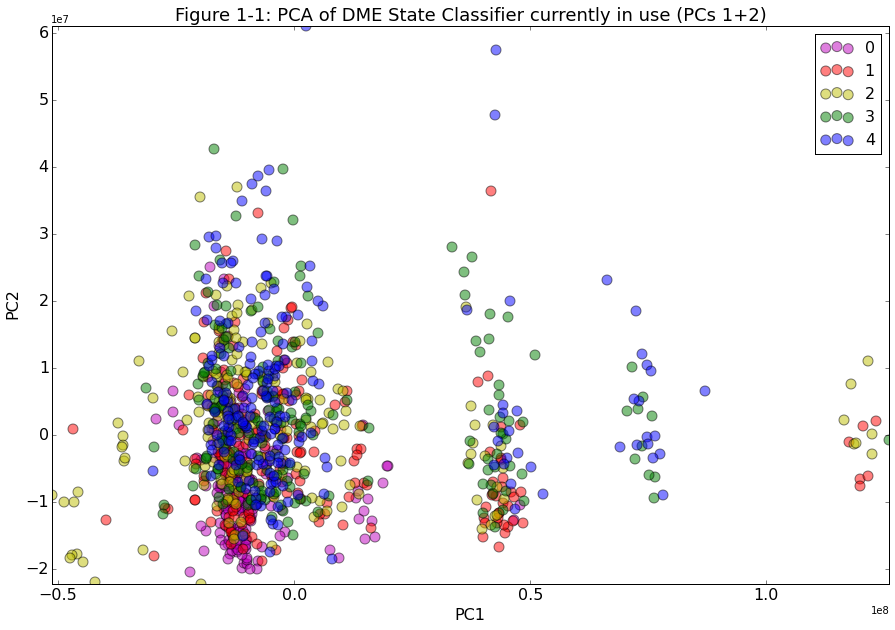

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( pca_featurespace[:,0].min(), pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( pca_featurespace[:,1].min(), pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
for class_name, color in zip( list(( '0', '1', '2', '3', '4') ), list(('m', 'r', 'y', 'g', 'b')) ):
    indices = np.where( [ gt == class_name for gt in stateB._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = pca_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 0], class_features[:, 1], c=color, label=class_name, s=100, alpha=0.50)
plt.tick_params( labelsize=16 )
ax.legend(fontsize=16)
ax.set_title('Figure 1-1: PCA of DME State Classifier currently in use (PCs 1+2)', size=18)
fig.show()

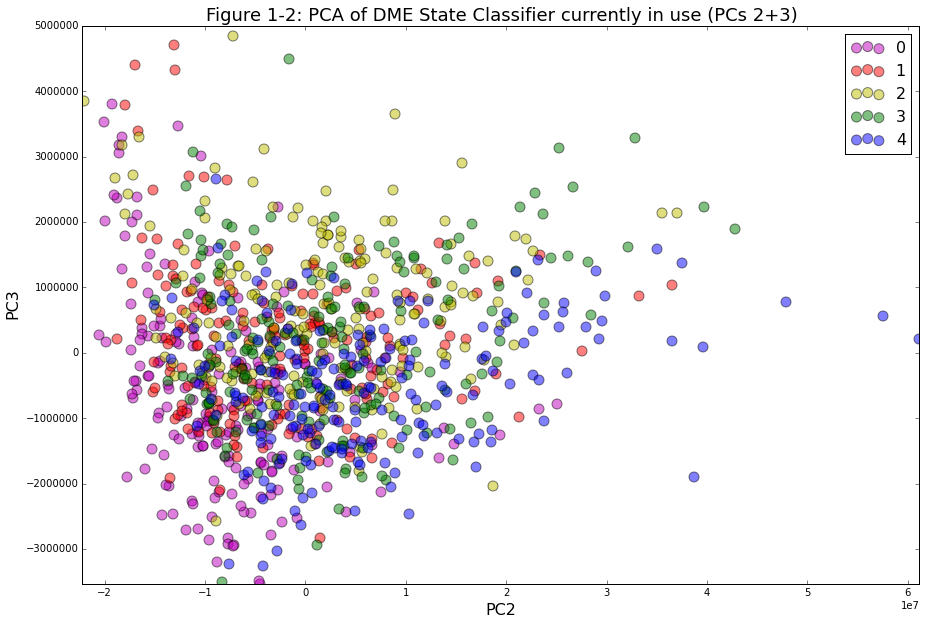

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( pca_featurespace[:,1].min(), pca_featurespace[:,1].max()  ) )
ax.set_xlabel( 'PC2', size=16 )
#ax.set_ylim( ( pca_featurespace[:,2].min(), pca_featurespace[:,2].max() ) )
ax.set_ylim( ( pca_featurespace[:,2].min(), 0.5e7 ) )
ax.set_ylabel( 'PC3', size=16 )
for class_name, color in zip( list(( '0', '1', '2', '3', '4') ), list(('m', 'r', 'y', 'g', 'b')) ):
    indices = np.where( [ gt == class_name for gt in stateB._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = pca_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 1], class_features[:, 2], c=color, label=class_name, s=100, alpha=0.50)
ax.legend(fontsize=16)
ax.set_title('Figure 1-2: PCA of DME State Classifier currently in use (PCs 2+3)', size=18)
fig.show()

Conclusion: PCA not helpful for characterizing state classifier. In data not shown, I did a feature reduce based on Fisher scores and did a PCA on teh reduced feature space and that didn't help either.

## LDA analysis of current state classifier

In [24]:
from sklearn.lda import LDA

In [25]:
lda_fitter = LDA(n_components=3)

In [26]:
lda_fitter.fit( stateB.data_matrix, stateB._contiguous_ground_truth_labels )

/usr/local/lib/python2.7/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA(n_components=3, priors=None, shrinkage=None, solver='svd',
  store_covariance=False, tol=0.0001)

In [27]:
lda_featurespace = lda_fitter.transform( stateB.data_matrix )

In [28]:
lda_featurespace.shape

(990, 3)

Like PCA, LDA dimensions are ordered with most informative features first, see:

In [29]:
mins = lda_featurespace.min(axis=0)
maxs = lda_featurespace.max(axis=0)
stdevs = lda_featurespace.std(axis=0)

for i, (n,x,d) in enumerate( zip( mins, maxs, stdevs) ):
    print i, n, x, d

0 -9.95966506717 11.8619109907 5.80496398749
1 -6.41974097431 7.02102818178 3.37621821892
2 -7.09079267332 6.35760796106 2.45496538086


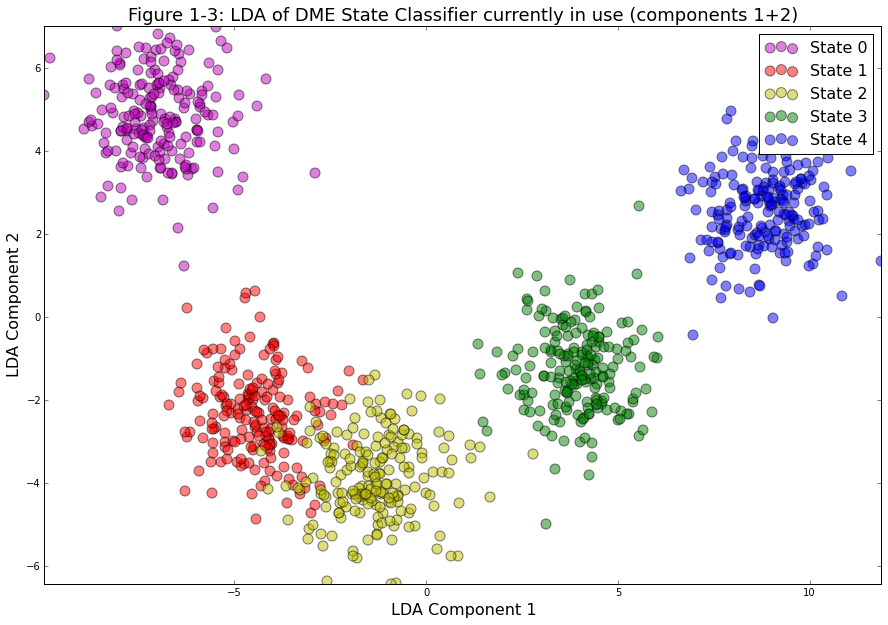

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( lda_featurespace[:,0].min(), lda_featurespace[:,0].max()  ) )
ax.set_xlabel( 'LDA Component 1', size=16)
ax.set_ylim( ( lda_featurespace[:,1].min(), lda_featurespace[:,1].max() ) )
ax.set_ylabel( 'LDA Component 2', size=16)
for class_name, color in zip( list(( '0', '1', '2', '3', '4') ), list(('m', 'r', 'y', 'g', 'b')) ):
    indices = np.where( [ gt == class_name for gt in stateB._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = lda_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 0], class_features[:, 1], c=color, label="State " + class_name, s=100, alpha=0.50)
ax.legend(fontsize=16)
ax.set_title('Figure 1-3: LDA of DME State Classifier currently in use (components 1+2)', size=18)
fig.show()

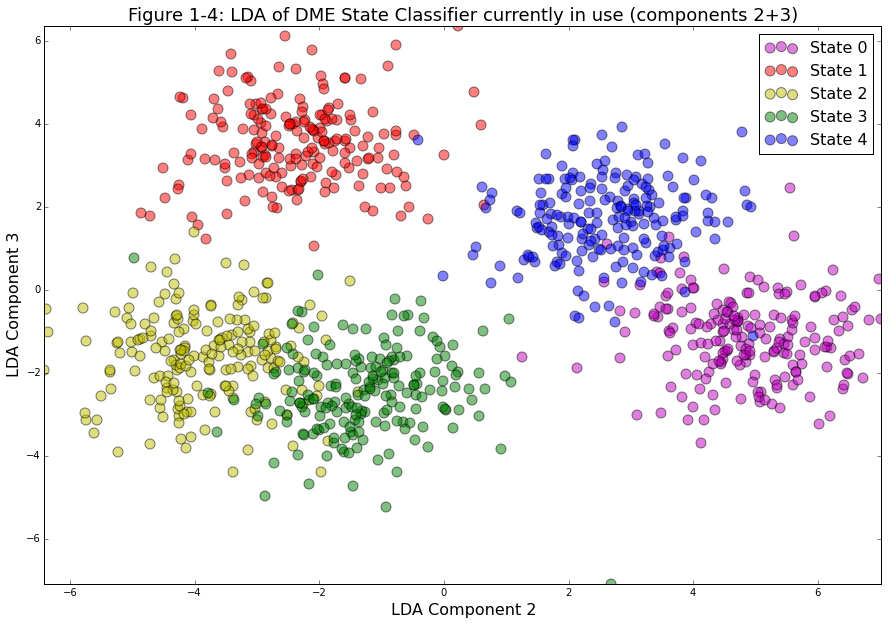

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( lda_featurespace[:,1].min(), lda_featurespace[:,1].max()  ) )
ax.set_xlabel( 'LDA Component 2', size=16)
ax.set_ylim( ( lda_featurespace[:,2].min(), lda_featurespace[:,2].max() ) )
ax.set_ylabel( 'LDA Component 3', size=16)
for class_name, color in zip( list(( '0', '1', '2', '3', '4') ), list(('m', 'r', 'y', 'g', 'b')) ):
    indices = np.where( [ gt == class_name for gt in stateB._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = lda_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 1], class_features[:, 2], c=color, label="State " + class_name, s=100, alpha=0.50)
ax.legend(fontsize=16)
ax.set_title('Figure 1-4: LDA of DME State Classifier currently in use (components 2+3)', size=18)
fig.show()

## WND-CHARM performance of current state classifier

Fit-on-fit:

In [34]:
from wndcharm.FeatureSpacePrediction import FeatureSpaceClassification

In [35]:
from wndcharm.FeatureWeights import FisherFeatureWeights

In [36]:
stateB_norm = stateB.Normalize( inplace=False)

NORMALIZED FEATURES AGAINST SELF FOR FEATURE SPACE: <FeatureSpace "StateBalanced.fit" n_features=2919 n_total_samples=990 n_samples_per_group=1 n_classes=5 samples_per_class=("0": 198, "1": 198, "2": 198, "3": 198, "4": 198)>


In [37]:
fw = FisherFeatureWeights.NewFromFeatureSpace( stateB_norm ).Threshold()

In [38]:
fw.Print(150)

FisherFeatureWeights (437 features)
Rank	Value	Name
====	=====	====
1	3.123796	Zernike Coefficients (Fourier ()) [54]
2	2.855040	Zernike Coefficients (Fourier (Wavelet ())) [52]
3	2.691643	Zernike Coefficients (Fourier ()) [28]
4	2.590438	Zernike Coefficients (Fourier ()) [19]
5	2.521594	Zernike Coefficients (Fourier ()) [69]
6	2.466041	Zernike Coefficients (Fourier ()) [41]
7	2.081823	Zernike Coefficients (Fourier (Wavelet ())) [39]
8	1.961121	Zernike Coefficients (Fourier ()) [5]
9	1.879932	Zernike Coefficients (Fourier (Wavelet ())) [69]
10	1.676869	Zernike Coefficients (Fourier ()) [71]
11	1.667345	Zernike Coefficients (Fourier ()) [39]
12	1.308971	Haralick Textures () [23]
13	1.295556	Zernike Coefficients (Fourier (Wavelet ())) [10]
14	1.251835	Zernike Coefficients (Fourier (Wavelet ())) [65]
15	1.249517	Haralick Textures () [5]
16	1.151672	Haralick Textures () [19]
17	1.134198	Haralick Textures () [4]
18	1.096626	Zernike Coefficients (Fourier ()) [10]
19	1.096420	Comb Moments (Fo

In [39]:
stateB_norm.FeatureReduce( fw, inplace=True )

FEATURE-REDUCED FEATURE SPACE (orig len 2919) <FeatureSpace "StateBalanced.fit (feature reduced)" n_features=437 n_total_samples=990 n_samples_per_group=1 n_classes=5 samples_per_class=("0": 198, "1": 198, "2": 198, "3": 198, "4": 198)>:'


<FeatureSpace "StateBalanced.fit (feature reduced)" n_features=437 n_total_samples=990 n_samples_per_group=1 n_classes=5 samples_per_class=("0": 198, "1": 198, "2": 198, "3": 198, "4": 198)>

In [40]:
split = FeatureSpaceClassification.NewWND5( stateB_norm, stateB_norm, fw, name='Table 1-1: Fit on fit classification of current state classifier', quiet=True)

In [41]:
split.Print()

FeatureSpaceClassification "Table 1-1: Fit on fit classification of current state classifier" (990 classifications)
813/990 correct = 82.12%
Standard Error: 0.3861
Pearson Coefficient: 0.9625
Coefficient of Determination (r^2): 0.9264
Spearman Coefficient: 0.9588


Confusion Matrix:
 	0	1	2	3	4	|	total	acc.
 	-	-	-	-	-	|	-----	----
0	188	9	0	0	1	|	198	94.95%
1	32	136	30	0	0	|	198	68.69%
2	3	32	140	23	0	|	198	70.71%
3	2	0	10	161	25	|	198	81.31%
4	0	0	0	10	188	|	198	94.95%

Similarity Matrix:
 	0	1	2	3	4
 	-	-	-	-	-
0	1.00	0.17	0.03	0.01	0.01	
1	0.38	1.00	0.45	0.03	0.00	
2	0.07	0.44	1.00	0.24	0.02	
3	0.03	0.04	0.21	1.00	0.32	
4	0.01	0.00	0.01	0.22	1.00	

Average Class Probability Matrix:
 	0	1	2	3	4
 	-	-	-	-	-
0	0.8262	0.1374	0.0250	0.0072	0.0043	
1	0.2060	0.5356	0.2385	0.0179	0.0020	
2	0.0378	0.2479	0.5657	0.1370	0.0117	
3	0.0157	0.0232	0.1332	0.6251	0.2028	
4	0.0042	0.0017	0.0099	0.1751	0.8090	



Now try using the same train test split params as those to be used in following sections, i.e. i=65, j=6, n=100, f=0.15

In [42]:
from wndcharm.FeatureSpacePredictionExperiment import FeatureSpaceClassificationExperiment

In [40]:
import time

In [41]:
t1 = time.time()
exp = FeatureSpaceClassificationExperiment.NewShuffleSplit( stateB, n_iter=1000, name='Table 1-2: WND-CHARM shuffle-split results for current state classifier (params i=65, j=6, f=0.15)', \
                                            features_size=0.15, train_size=65, test_size=6, lda=False, progress=False)
t2 = time.time()
print "1000 splits took {:0.2f} minutes to complete".format( (t2-t1)/60 )

1000 splits took 1.50 minutes to complete


In [42]:
exp.Print()

FeatureSpaceClassificationExperiment "Table 1-2: WND-CHARM shuffle-split results for current state classifier (params i=65, j=6, f=0.15)" (1000 iterations)
23349/30000 correct = 77.83 +/- 0.47% w/ 95% conf. (normal approx. interval)
Standard Error: 0.4199
Pearson Corellation Coefficient (r): 0.9554
Coefficient of Determination (r^2): 0.9129
Spearman Coefficient: 0.9518


Confusion Matrix:
 	0	1	2	3	4	|	total	acc.
 	-	-	-	-	-	|	-----	----
0	5556	400	22	7	15	|	6000	92.60%
1	987	3933	1062	18	0	|	6000	65.55%
2	97	1146	3984	770	3	|	6000	66.40%
3	66	19	361	4507	1047	|	6000	75.12%
4	2	0	4	625	5369	|	6000	89.48%


Similarity Matrix:
 	0	1	2	3	4
 	-	-	-	-	-
0	1.00	0.18	0.04	0.01	0.00	
1	0.42	1.00	0.49	0.04	0.00	
2	0.08	0.49	1.00	0.27	0.02	
3	0.03	0.05	0.24	1.00	0.35	
4	0.01	0.00	0.02	0.24	1.00	


Average Class Probability Matrix:
 	0	1	2	3	4
 	-	-	-	-	-
0	0.8069	0.1492	0.0318	0.0085	0.0036	
1	0.2126	0.5120	0.2520	0.0209	0.0024	
2	0.0424	0.2631	0.5353	0.1458	0.0134	
3	0.0181	0.0286	0.1424	0.6004

In [43]:
from wndcharm.visualization import PredictedValuesGraph

In [44]:
graph = PredictedValuesGraph( exp, figsize=(15,10) )

Rendering kernel-smoothed probability density estimate graph


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


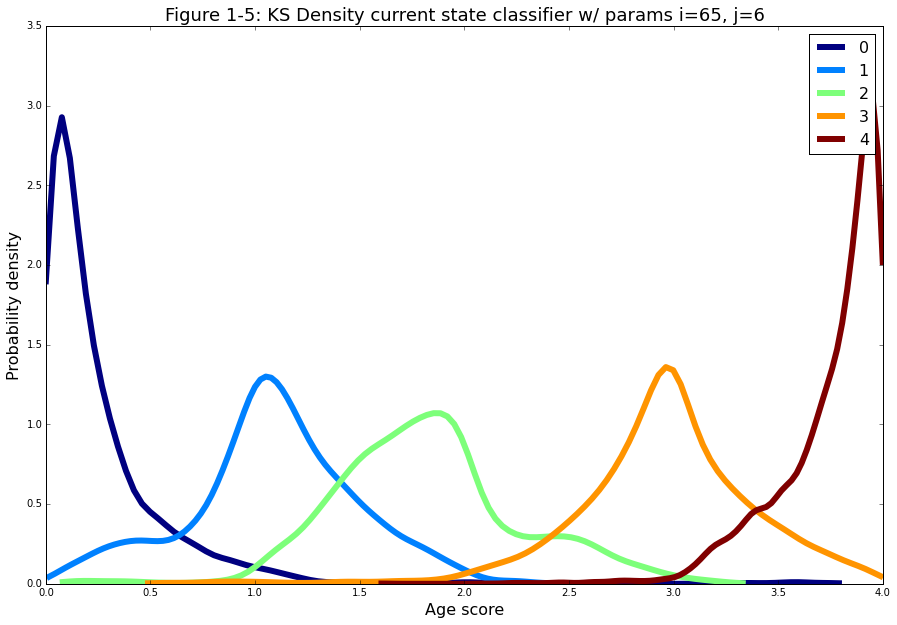

In [45]:
graph.KernelSmoothedDensityGraph( chart_title='Figure 1-5: KS Density current state classifier w/ params i=65, j=6')

# Output features to TSV

I gave this data to Jun Ding to reproduce my graphs using R, he did and they were identical.

In [68]:
np.savetxt( 'original_featurespace_990rows_2919cols.tsv', stateB.data_matrix, fmt='%0.5g', delimiter='\t')

In [69]:
with open( 'sample_labels_990rows_1col.tsv', 'w') as out:
    for label in stateB._contiguous_ground_truth_labels:
        out.write( label + '\n')

In [70]:
with open( 'sample_colors_990rows_1col.tsv', 'w') as out:
    for color in list(('red', 'green', 'blue', 'yellow', 'magenta')):
        for i in xrange( 198 ):
            out.write( color + '\n')

# Recalculate features for DME-collected "All days" dataset

Copy data from /Volumes/NIAIRP/LG/ome/dme/April_May2013Pharynx/All/All/DME to lgchrm19 and calculate new features

In [43]:
age = FeatureSpace.NewFromFitFile('dme_c_elegans_lifeaspan_v3.2features.fit')

LOADED FEATURE SPACE FROM WND-CHARM .fit FILE dme_c_elegans_lifeaspan_v3.2features.fit: <FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit" n_features=2919 n_total_samples=3870 n_samples_per_group=1 n_classes=14 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "09": 171, "10": 201, "11": 143, "12": 406, "13": 71)>


In [44]:
age.feature_set_version

'3.2'

In [45]:
age.Print()

Summary of FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit":
Total samples: 3870 (3870 groups, 1 samples/group)
Total num features: 2919
Feature Set Version: 3.2
	Class 0 "00": 180 samples (180 groups)
	Class 1 "01": 412 samples (412 groups)
	Class 2 "02": 240 samples (240 groups)
	Class 3 "03": 167 samples (167 groups)
	Class 4 "04": 215 samples (215 groups)
	Class 5 "05": 589 samples (589 groups)
	Class 6 "06": 316 samples (316 groups)
	Class 7 "07": 405 samples (405 groups)
	Class 8 "08": 354 samples (354 groups)
	Class 9 "09": 171 samples (171 groups)
	Class 10 "10": 201 samples (201 groups)
	Class 11 "11": 143 samples (143 groups)
	Class 12 "12": 406 samples (406 groups)
	Class 13 "13": 71 samples (71 groups)



# Section 2: Using PCA to examine intra-class heterogeneity for each day

As you'll see below, you can use this method to help identify batches that are artifactually distinct, perhaps due to sample prep. Look for the grouping of like-named individuals in the plot. (See days 03 and 05)

In [46]:
age.data_matrix.shape

(3870, 2919)

In [47]:
age.data_list[0].shape

(180, 2919)

In [48]:
day00_pca_fitter = PCA(n_components=3)
day00_pca_fitter.fit( age.data_list[0] )
day00_pca_featurespace = day00_pca_fitter.transform( age.data_list[0] )

In [49]:
day00_pca_fitter.explained_variance_ratio_

array([ 0.5764724 ,  0.37961213,  0.02939672])

In [50]:
day00_pca_featurespace.shape

(180, 3)

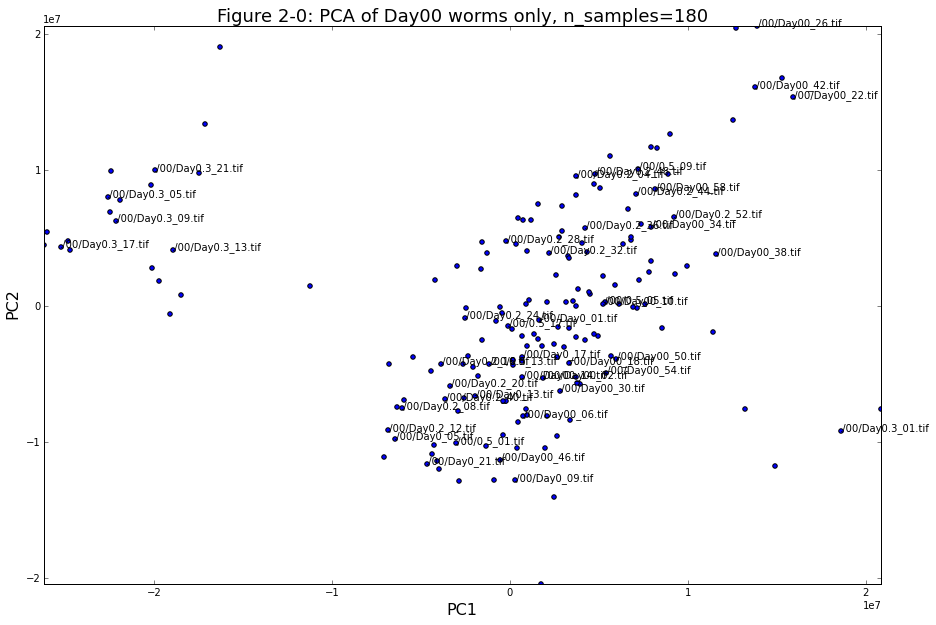

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day00_pca_featurespace[:,0].min(), day00_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day00_pca_featurespace[:,1].min(), day00_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day00_pca_featurespace[:, 0], day00_pca_featurespace[:, 1], c='b', label='day00')
ax.set_title('Figure 2-0: PCA of Day00 worms only, n_samples={}'.format( age.data_list[0].shape[0] ), size=18)
for i, (xy) in enumerate( zip( day00_pca_featurespace[:, 0], day00_pca_featurespace[:, 1] ) ):
    if i % 4 == 0:
        ax.annotate( age.sample_names[0][i] , xy=xy )
fig.show()

In [52]:
day01_pca_fitter = PCA(n_components=3)
day01_pca_fitter.fit( age.data_list[1] )
day01_pca_fitter.explained_variance_ratio_

array([ 0.8465623 ,  0.14436351,  0.00659867])

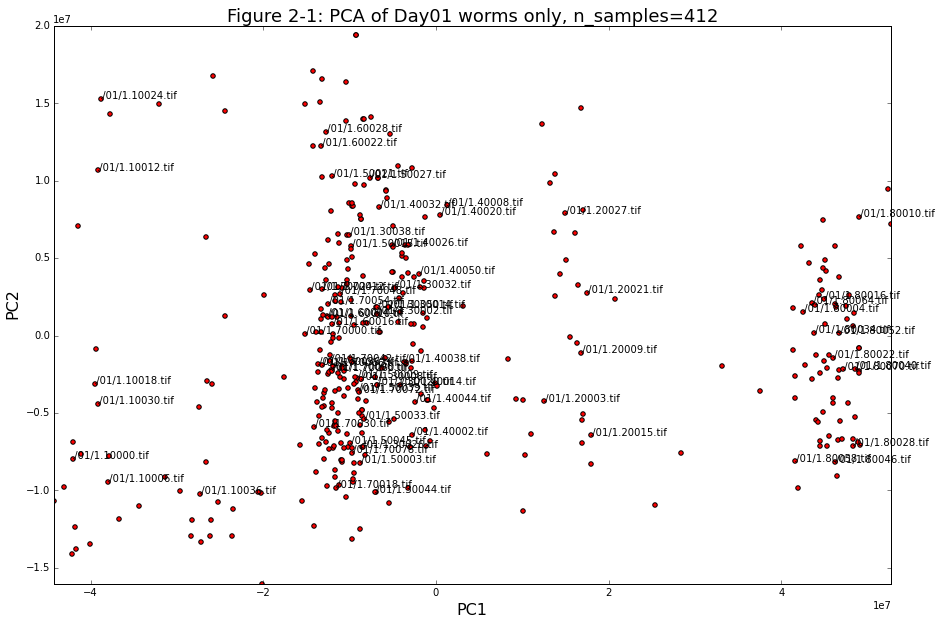

In [53]:
day01_pca_featurespace = day01_pca_fitter.transform( age.data_list[1] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day01_pca_featurespace[:,0].min(), day01_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
#ax.set_ylim( ( day01_pca_featurespace[:,1].min(), day01_pca_featurespace[:,1].max() ) )
ax.set_ylim( ( day01_pca_featurespace[:,1].min(), 2e7 ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day01_pca_featurespace[:, 0], day01_pca_featurespace[:, 1], c='r', label='day01')

for i, (xy) in enumerate( zip( day01_pca_featurespace[:, 0], day01_pca_featurespace[:, 1] ) ):
    if i % 6 == 0:
        try:
            ax.annotate( age.sample_names[1][i] , xy=xy )
        except ValueError:
            pass

ax.set_title('Figure 2-1: PCA of Day01 worms only, n_samples={}'.format( age.data_list[1].shape[0] ), size=18)
fig.show()

In [54]:
day02_pca_fitter = PCA(n_components=3)
day02_pca_fitter.fit( age.data_list[2] )
day02_pca_fitter.explained_variance_ratio_

array([ 0.80550493,  0.17108753,  0.0200442 ])

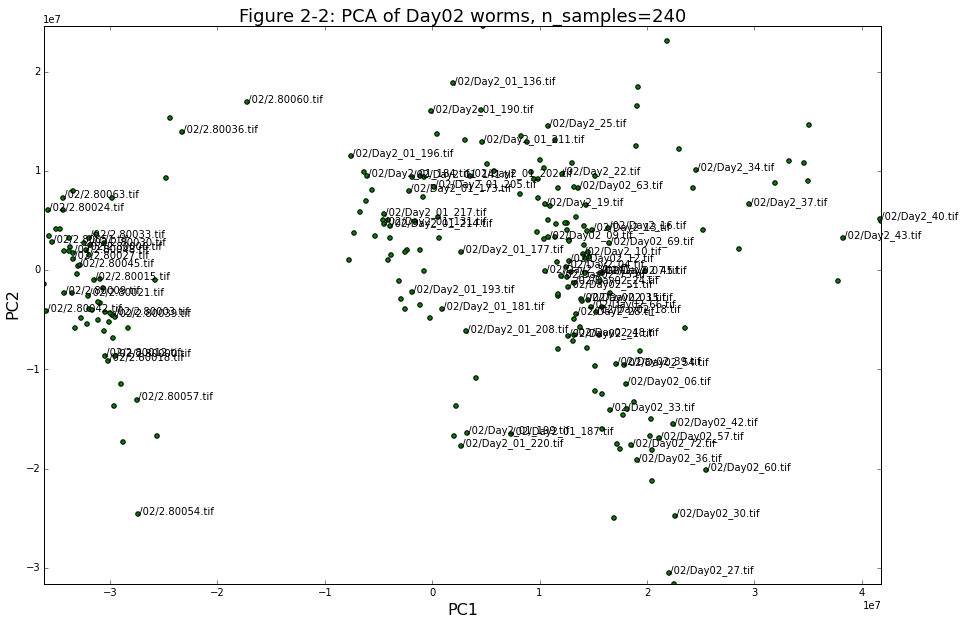

In [55]:
day02_pca_featurespace = day02_pca_fitter.transform( age.data_list[2] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day02_pca_featurespace[:,0].min(), day02_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day02_pca_featurespace[:,1].min(), day02_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day02_pca_featurespace[:, 0], day02_pca_featurespace[:, 1], c='g', label='day02')

for i, (xy) in enumerate( zip( day02_pca_featurespace[:, 0], day02_pca_featurespace[:, 1] ) ):
    if i % 3 == 0:
        ax.annotate( age.sample_names[2][i] , xy=xy )

ax.set_title('Figure 2-2: PCA of Day02 worms, n_samples={}'.format( age.data_list[2].shape[0] ), size=18)
fig.show()

In [56]:
day03_pca_fitter = PCA(n_components=3)
day03_pca_fitter.fit( age.data_list[3] )
day03_pca_fitter.explained_variance_ratio_

array([  9.85043489e-01,   1.40706014e-02,   4.43251152e-04])

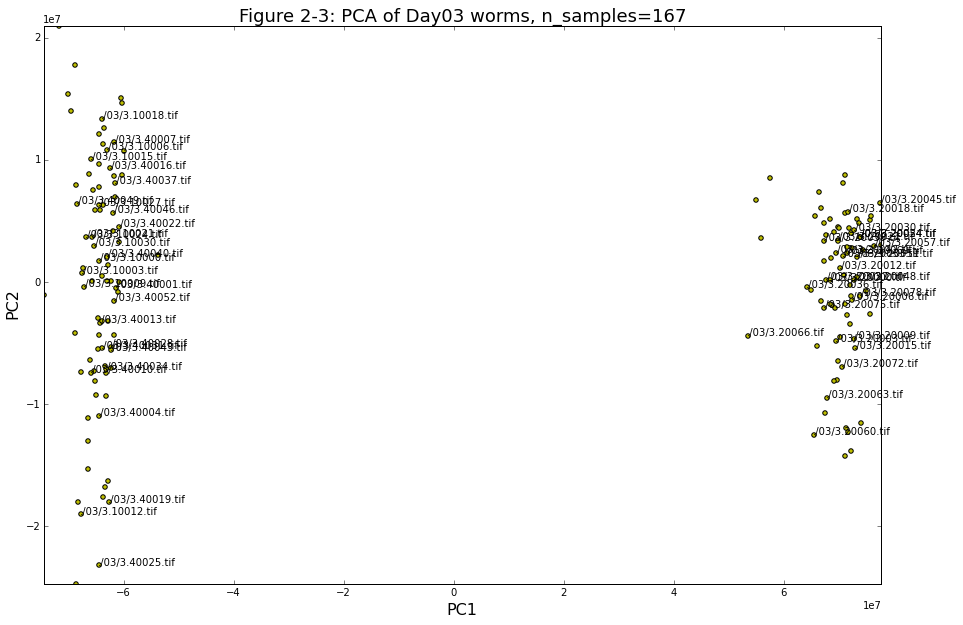

In [57]:
day03_pca_featurespace = day03_pca_fitter.transform( age.data_list[3] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day03_pca_featurespace[:,0].min(), day03_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day03_pca_featurespace[:,1].min(), day03_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day03_pca_featurespace[:, 0], day03_pca_featurespace[:, 1], c='y', label='day03')

for i, (xy) in enumerate( zip( day03_pca_featurespace[:, 0], day03_pca_featurespace[:, 1] ) ):
    label = age.sample_names[3][i]
    #print i, xy, label
    # print only every 4th label
    if i % 3 == 0:
        ax.annotate( label, xy=xy )
ax.set_title('Figure 2-3: PCA of Day03 worms, n_samples={}'.format( age.data_list[3].shape[0] ), size=18)
fig.show()

In [58]:
day04_pca_fitter = PCA(n_components=3)
day04_pca_fitter.fit( age.data_list[4] )
day04_pca_fitter.explained_variance_ratio_

array([ 0.60699275,  0.37880476,  0.00665188])

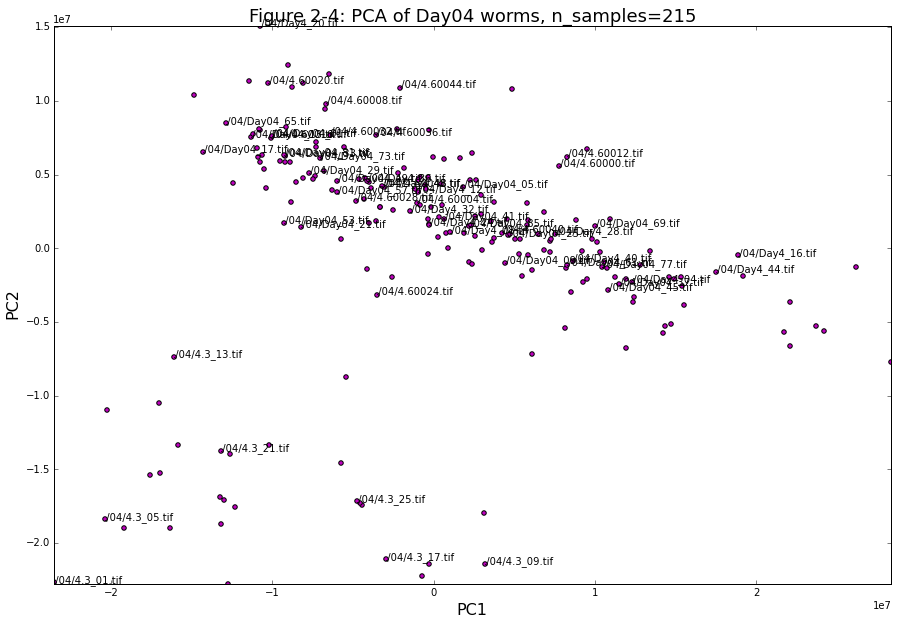

In [59]:
day04_pca_featurespace = day04_pca_fitter.transform( age.data_list[4] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day04_pca_featurespace[:,0].min(), day04_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16 )
ax.set_ylim( ( day04_pca_featurespace[:,1].min(), day04_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16 )
ax.scatter( day04_pca_featurespace[:, 0], day04_pca_featurespace[:, 1], c='m', label='day04')
for i, (xy) in enumerate( zip( day04_pca_featurespace[:, 0], day04_pca_featurespace[:, 1] ) ):
    label = age.sample_names[4][i]
    #print i, xy, label
    # print only every 4th label
    if i % 4 == 0:
        ax.annotate( label, xy=xy )
ax.set_title('Figure 2-4: PCA of Day04 worms, n_samples={}'.format( age.data_list[4].shape[0] ) , size=18)
fig.show()

In [64]:
day05_pca_fitter = PCA(n_components=3)
day05_pca_fitter.fit( age.data_list[5] )
day05_pca_fitter.explained_variance_ratio_

array([ 0.02471997,  0.02452759,  0.02299564])

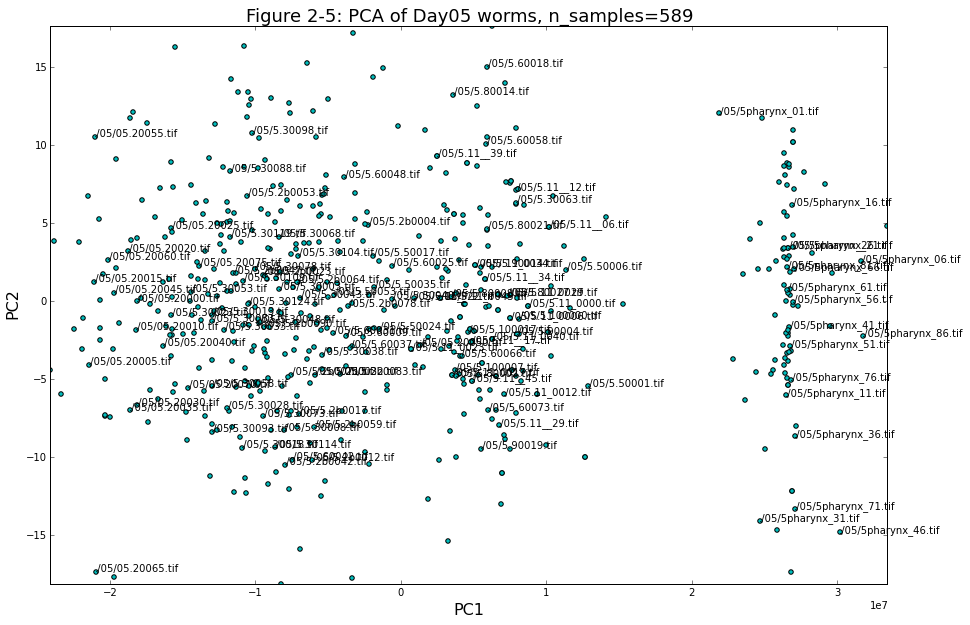

In [65]:
day05_pca_featurespace = day05_pca_fitter.transform( age.data_list[5] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day05_pca_featurespace[:,0].min(), day05_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day05_pca_featurespace[:,1].min(), day05_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day05_pca_featurespace[:, 0], day05_pca_featurespace[:, 1], c='c', label='day05')

for i, (xy) in enumerate( zip( day05_pca_featurespace[:, 0], day05_pca_featurespace[:, 1] ) ):
    if i % 5 == 0:
        ax.annotate( age.sample_names[5][i] , xy=xy )

ax.set_title('Figure 2-5: PCA of Day05 worms, n_samples={}'.format( age.data_list[5].shape[0] ) , size=18)
fig.show()

In [66]:
day06_pca_fitter = PCA(n_components=3)
day06_pca_fitter.fit( age.data_list[6] )
day06_pca_fitter.explained_variance_ratio_

array([ 0.5982003 ,  0.38995011,  0.00578523])

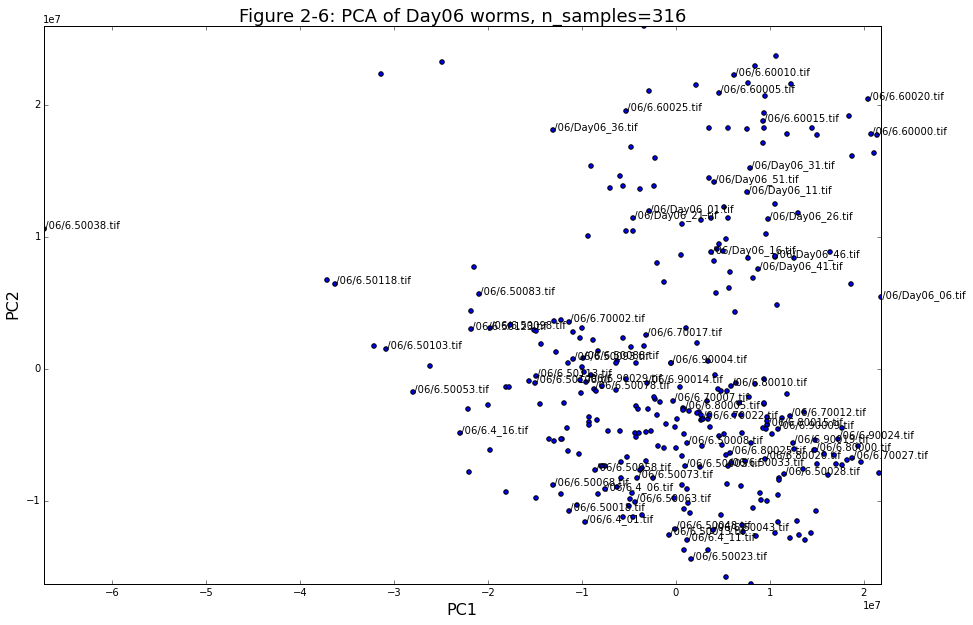

In [67]:
day06_pca_featurespace = day06_pca_fitter.transform( age.data_list[6] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day06_pca_featurespace[:,0].min(), day06_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day06_pca_featurespace[:,1].min(), day06_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day06_pca_featurespace[:, 0], day06_pca_featurespace[:, 1], c='b', label='day06')
for i, (xy) in enumerate( zip( day06_pca_featurespace[:, 0], day06_pca_featurespace[:, 1] ) ):
    if i % 5 == 0:
        ax.annotate( age.sample_names[6][i] , xy=xy )
ax.set_title('Figure 2-6: PCA of Day06 worms, n_samples={}'.format( age.data_list[6].shape[0] ) , size=18)
fig.show()

In [68]:
day07_pca_fitter = PCA(n_components=3)
day07_pca_fitter.fit( age.data_list[7] )
day07_pca_fitter.explained_variance_ratio_

array([ 0.78202364,  0.2080329 ,  0.00567319])

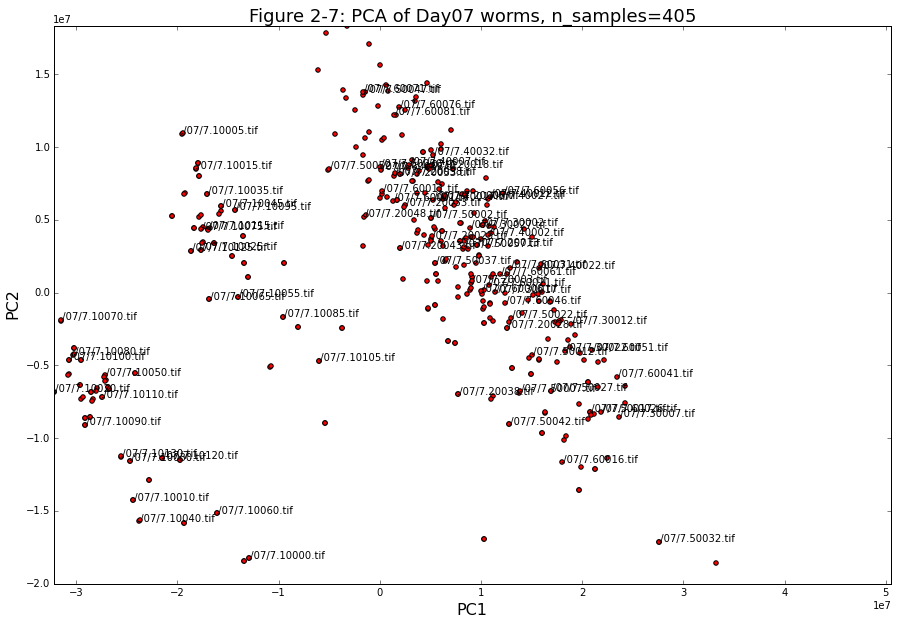

In [69]:
day07_pca_featurespace = day07_pca_fitter.transform( age.data_list[7] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day07_pca_featurespace[:,0].min(), day07_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
#ax.set_ylim( ( day07_pca_featurespace[:,1].min(), day07_pca_featurespace[:,1].max() ) )
ax.set_ylim( ( -2e7, day07_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day07_pca_featurespace[:, 0], day07_pca_featurespace[:, 1], c='r', label='day07')
for i, (xy) in enumerate( zip( day07_pca_featurespace[:, 0], day07_pca_featurespace[:, 1] ) ):
    if i % 5 == 0:
        ax.annotate( age.sample_names[7][i] , xy=xy )
ax.set_title('Figure 2-7: PCA of Day07 worms, n_samples={}'.format( age.data_list[7].shape[0] ), size=18)
fig.show()

In [70]:
day08_pca_fitter = PCA(n_components=3)
day08_pca_fitter.fit( age.data_list[8] )
day08_pca_fitter.explained_variance_ratio_

array([ 0.81922281,  0.17596564,  0.00216606])

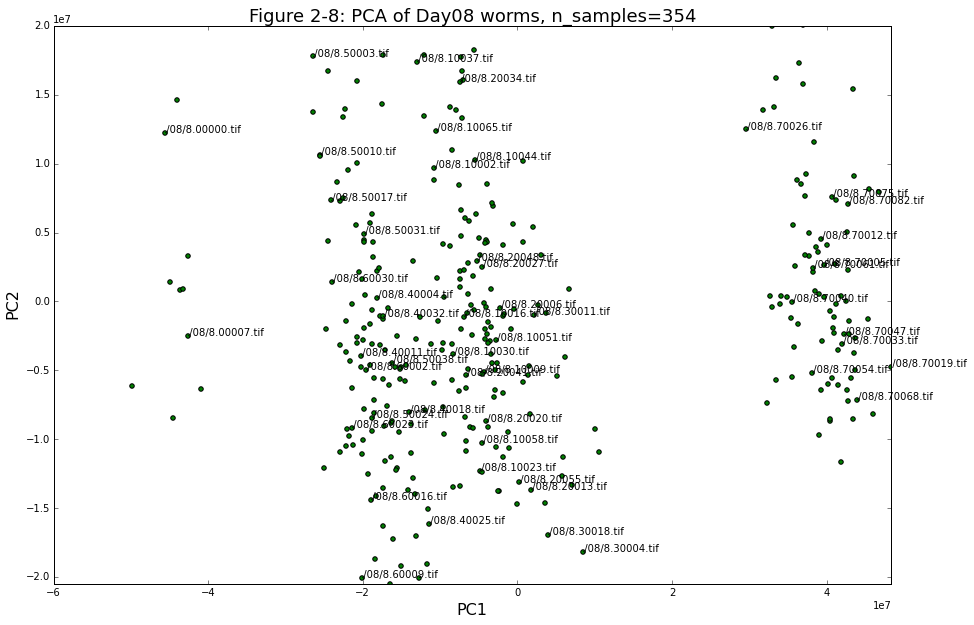

In [71]:
day08_pca_featurespace = day08_pca_fitter.transform( age.data_list[8] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day08_pca_featurespace[:,0].min(), day08_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
#ax.set_ylim( ( day08_pca_featurespace[:,1].min(), day08_pca_featurespace[:,1].max() ) )
ax.set_ylim( ( day08_pca_featurespace[:,1].min(), 2e7 ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day08_pca_featurespace[:, 0], day08_pca_featurespace[:, 1], c='g', label='day08')
for i, (xy) in enumerate( zip( day08_pca_featurespace[:, 0], day08_pca_featurespace[:, 1] ) ):
    if i % 7 == 0:
        ax.annotate( age.sample_names[8][i] , xy=xy )
ax.set_title('Figure 2-8: PCA of Day08 worms, n_samples={}'.format( age.data_list[8].shape[0] ), size=18)
fig.show()

In [72]:
day09_pca_fitter = PCA(n_components=3)
day09_pca_fitter.fit( age.data_list[9] )
day09_pca_fitter.explained_variance_ratio_

array([ 0.87371752,  0.09787376,  0.01674496])

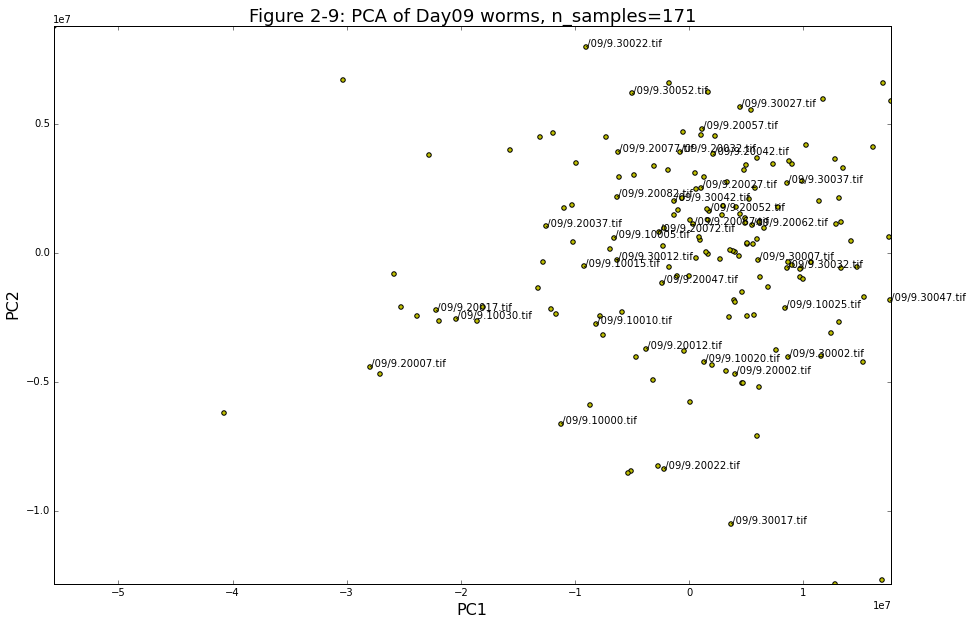

In [73]:
day09_pca_featurespace = day09_pca_fitter.transform( age.data_list[9] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day09_pca_featurespace[:,0].min(), day09_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day09_pca_featurespace[:,1].min(), day09_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day09_pca_featurespace[:, 0], day09_pca_featurespace[:, 1], c='y', label='day09')
for i, (xy) in enumerate( zip( day09_pca_featurespace[:, 0], day09_pca_featurespace[:, 1] ) ):
    if i % 5 == 0:
        ax.annotate( age.sample_names[9][i] , xy=xy )
ax.set_title('Figure 2-9: PCA of Day09 worms, n_samples={}'.format( age.data_list[9].shape[0] ), size=18)
fig.show()

In [74]:
day10_pca_fitter = PCA(n_components=3)
day10_pca_fitter.fit( age.data_list[10] )
day10_pca_fitter.explained_variance_ratio_

array([ 0.57305526,  0.41209148,  0.00747927])

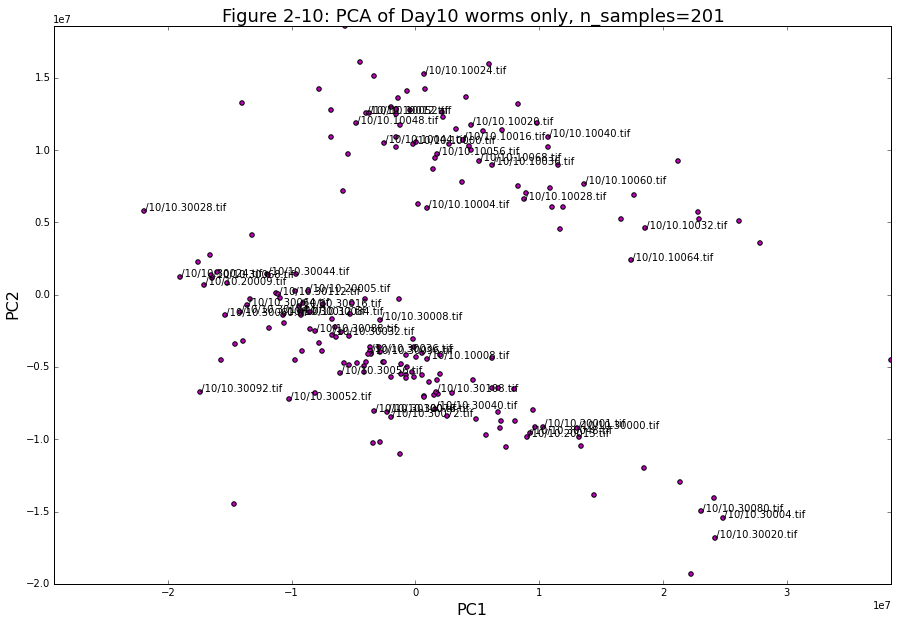

In [75]:
day10_pca_featurespace = day10_pca_fitter.transform( age.data_list[10] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day10_pca_featurespace[:,0].min(), day10_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
#ax.set_ylim( ( day10_pca_featurespace[:,1].min(), day10_pca_featurespace[:,1].max() ) )
ax.set_ylim( ( -2e7, day10_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day10_pca_featurespace[:, 0], day10_pca_featurespace[:, 1], c='m', label='day10')
for i, (xy) in enumerate( zip( day10_pca_featurespace[:, 0], day10_pca_featurespace[:, 1] ) ):
    if i % 4 == 0:
        ax.annotate( age.sample_names[10][i] , xy=xy )
ax.set_title('Figure 2-10: PCA of Day10 worms only, n_samples={}'.format( age.data_list[10].shape[0] ), size=18)
fig.show()

In [76]:
day11_pca_fitter = PCA(n_components=3)
day11_pca_fitter.fit( age.data_list[11] )
day11_pca_fitter.explained_variance_ratio_

array([ 0.93425244,  0.04664065,  0.01156373])

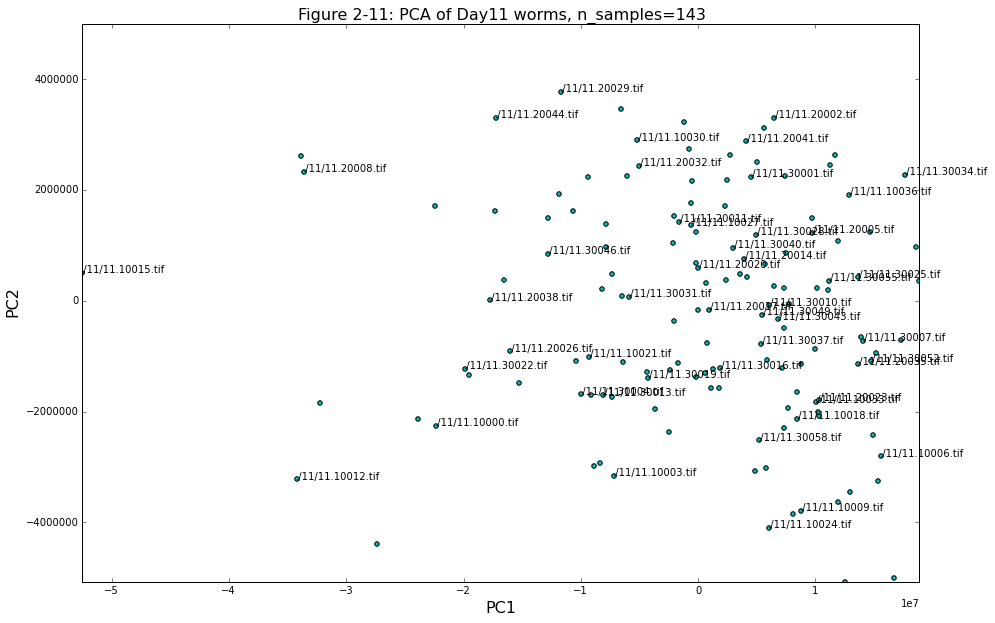

In [77]:
day11_pca_featurespace = day11_pca_fitter.transform( age.data_list[11] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day11_pca_featurespace[:,0].min(), day11_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
#ax.set_ylim( ( day11_pca_featurespace[:,1].min(), day11_pca_featurespace[:,1].max() ) )
ax.set_ylim( ( day11_pca_featurespace[:,1].min(), 0.5e7) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day11_pca_featurespace[:, 0], day11_pca_featurespace[:, 1], c='c', label='day11')
for i, (xy) in enumerate( zip( day11_pca_featurespace[:, 0], day11_pca_featurespace[:, 1] ) ):
    if i % 3 == 0:
        ax.annotate( age.sample_names[11][i] , xy=xy  )
ax.set_title('Figure 2-11: PCA of Day11 worms, n_samples={}'.format( age.data_list[11].shape[0] ), size=16)
fig.show()

In [78]:
day12_pca_fitter = PCA(n_components=3)
day12_pca_fitter.fit( age.data_list[12] )
day12_pca_fitter.explained_variance_ratio_

array([ 0.73089456,  0.25320601,  0.00893336])

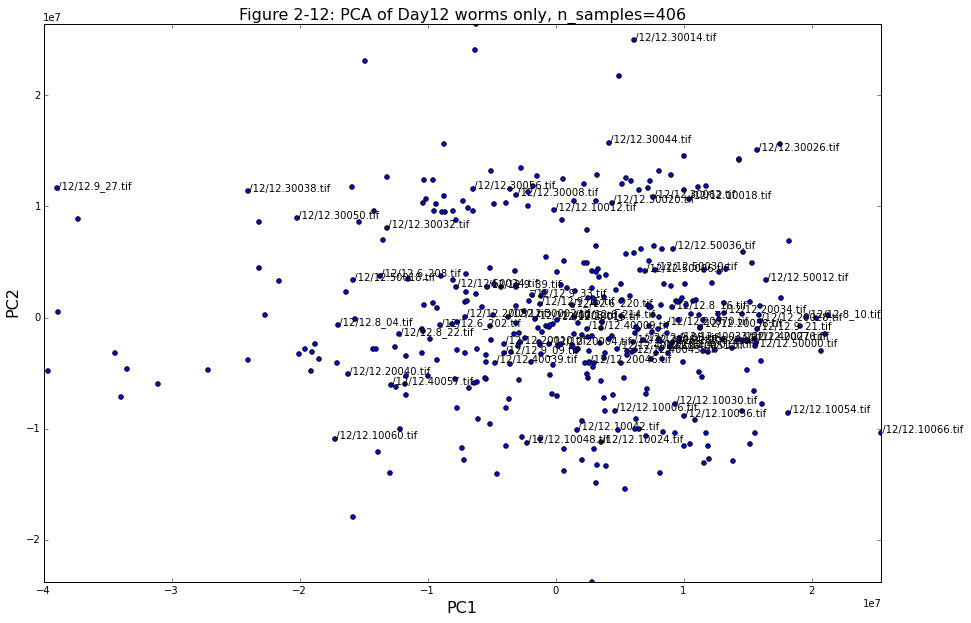

In [79]:
day12_pca_featurespace = day12_pca_fitter.transform( age.data_list[12] )
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_xlim( ( day12_pca_featurespace[:,0].min(), day12_pca_featurespace[:,0].max()  ) )
ax.set_xlim( ( -0.4e8, day12_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day12_pca_featurespace[:,1].min(), day12_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day12_pca_featurespace[:, 0], day12_pca_featurespace[:, 1], c='b', label='day12')
for i, (xy) in enumerate( zip( day12_pca_featurespace[:, 0], day12_pca_featurespace[:, 1] ), start=2):
    if i % 6 == 0:
        ax.annotate( age.sample_names[12][i] , xy=xy  )       
ax.set_title('Figure 2-12: PCA of Day12 worms only, n_samples={}'.format( age.data_list[12].shape[0] ), size=16)
fig.show()

In [80]:
day13_pca_fitter = PCA(n_components=3)
day13_pca_fitter.fit( age.data_list[13] )
day13_pca_fitter.explained_variance_ratio_

array([ 0.79692406,  0.12971031,  0.04506541])

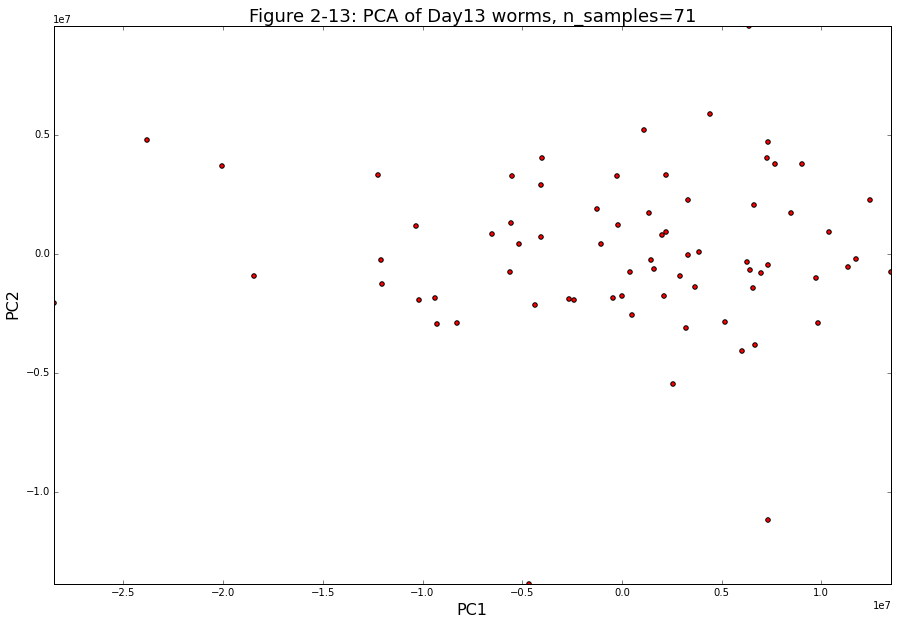

In [81]:
day13_pca_featurespace = day13_pca_fitter.transform( age.data_list[13] )
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( day13_pca_featurespace[:,0].min(), day13_pca_featurespace[:,0].max()  ) )
ax.set_xlabel( 'PC1', size=16)
ax.set_ylim( ( day13_pca_featurespace[:,1].min(), day13_pca_featurespace[:,1].max() ) )
ax.set_ylabel( 'PC2', size=16)
ax.scatter( day13_pca_featurespace[:, 0], day13_pca_featurespace[:, 1], c='r', label='day13')
ax.set_title('Figure 2-13: PCA of Day13 worms, n_samples={}'.format( age.data_list[13].shape[0] ), size=18)
fig.show()

# Section 3: PCA / LDA / WND-CHARM KS-density analysis of all 3870 Pharynxes 

In [82]:
all_pca_fitter = PCA(n_components=5)
all_pca_fitter.fit( age.data_matrix )
all_pca_fitter.explained_variance_ratio_

array([  8.53053844e-01,   1.41730299e-01,   2.70787381e-03,
         1.62289922e-03,   5.09433252e-04])

In [83]:
all_pca_featurespace = all_pca_fitter.transform( age.data_matrix )

In [84]:
class_labels = age.class_names
class_colors = plt.cm.jet( [ val/len(class_labels) for val in age.interpolation_coefficients] )
class_shapes = list(('o','v','^','<','>','s','p','*','h','H','8','D','d','o'))

In [85]:
print len(class_labels), len(class_colors), len(class_shapes)

14 14 14


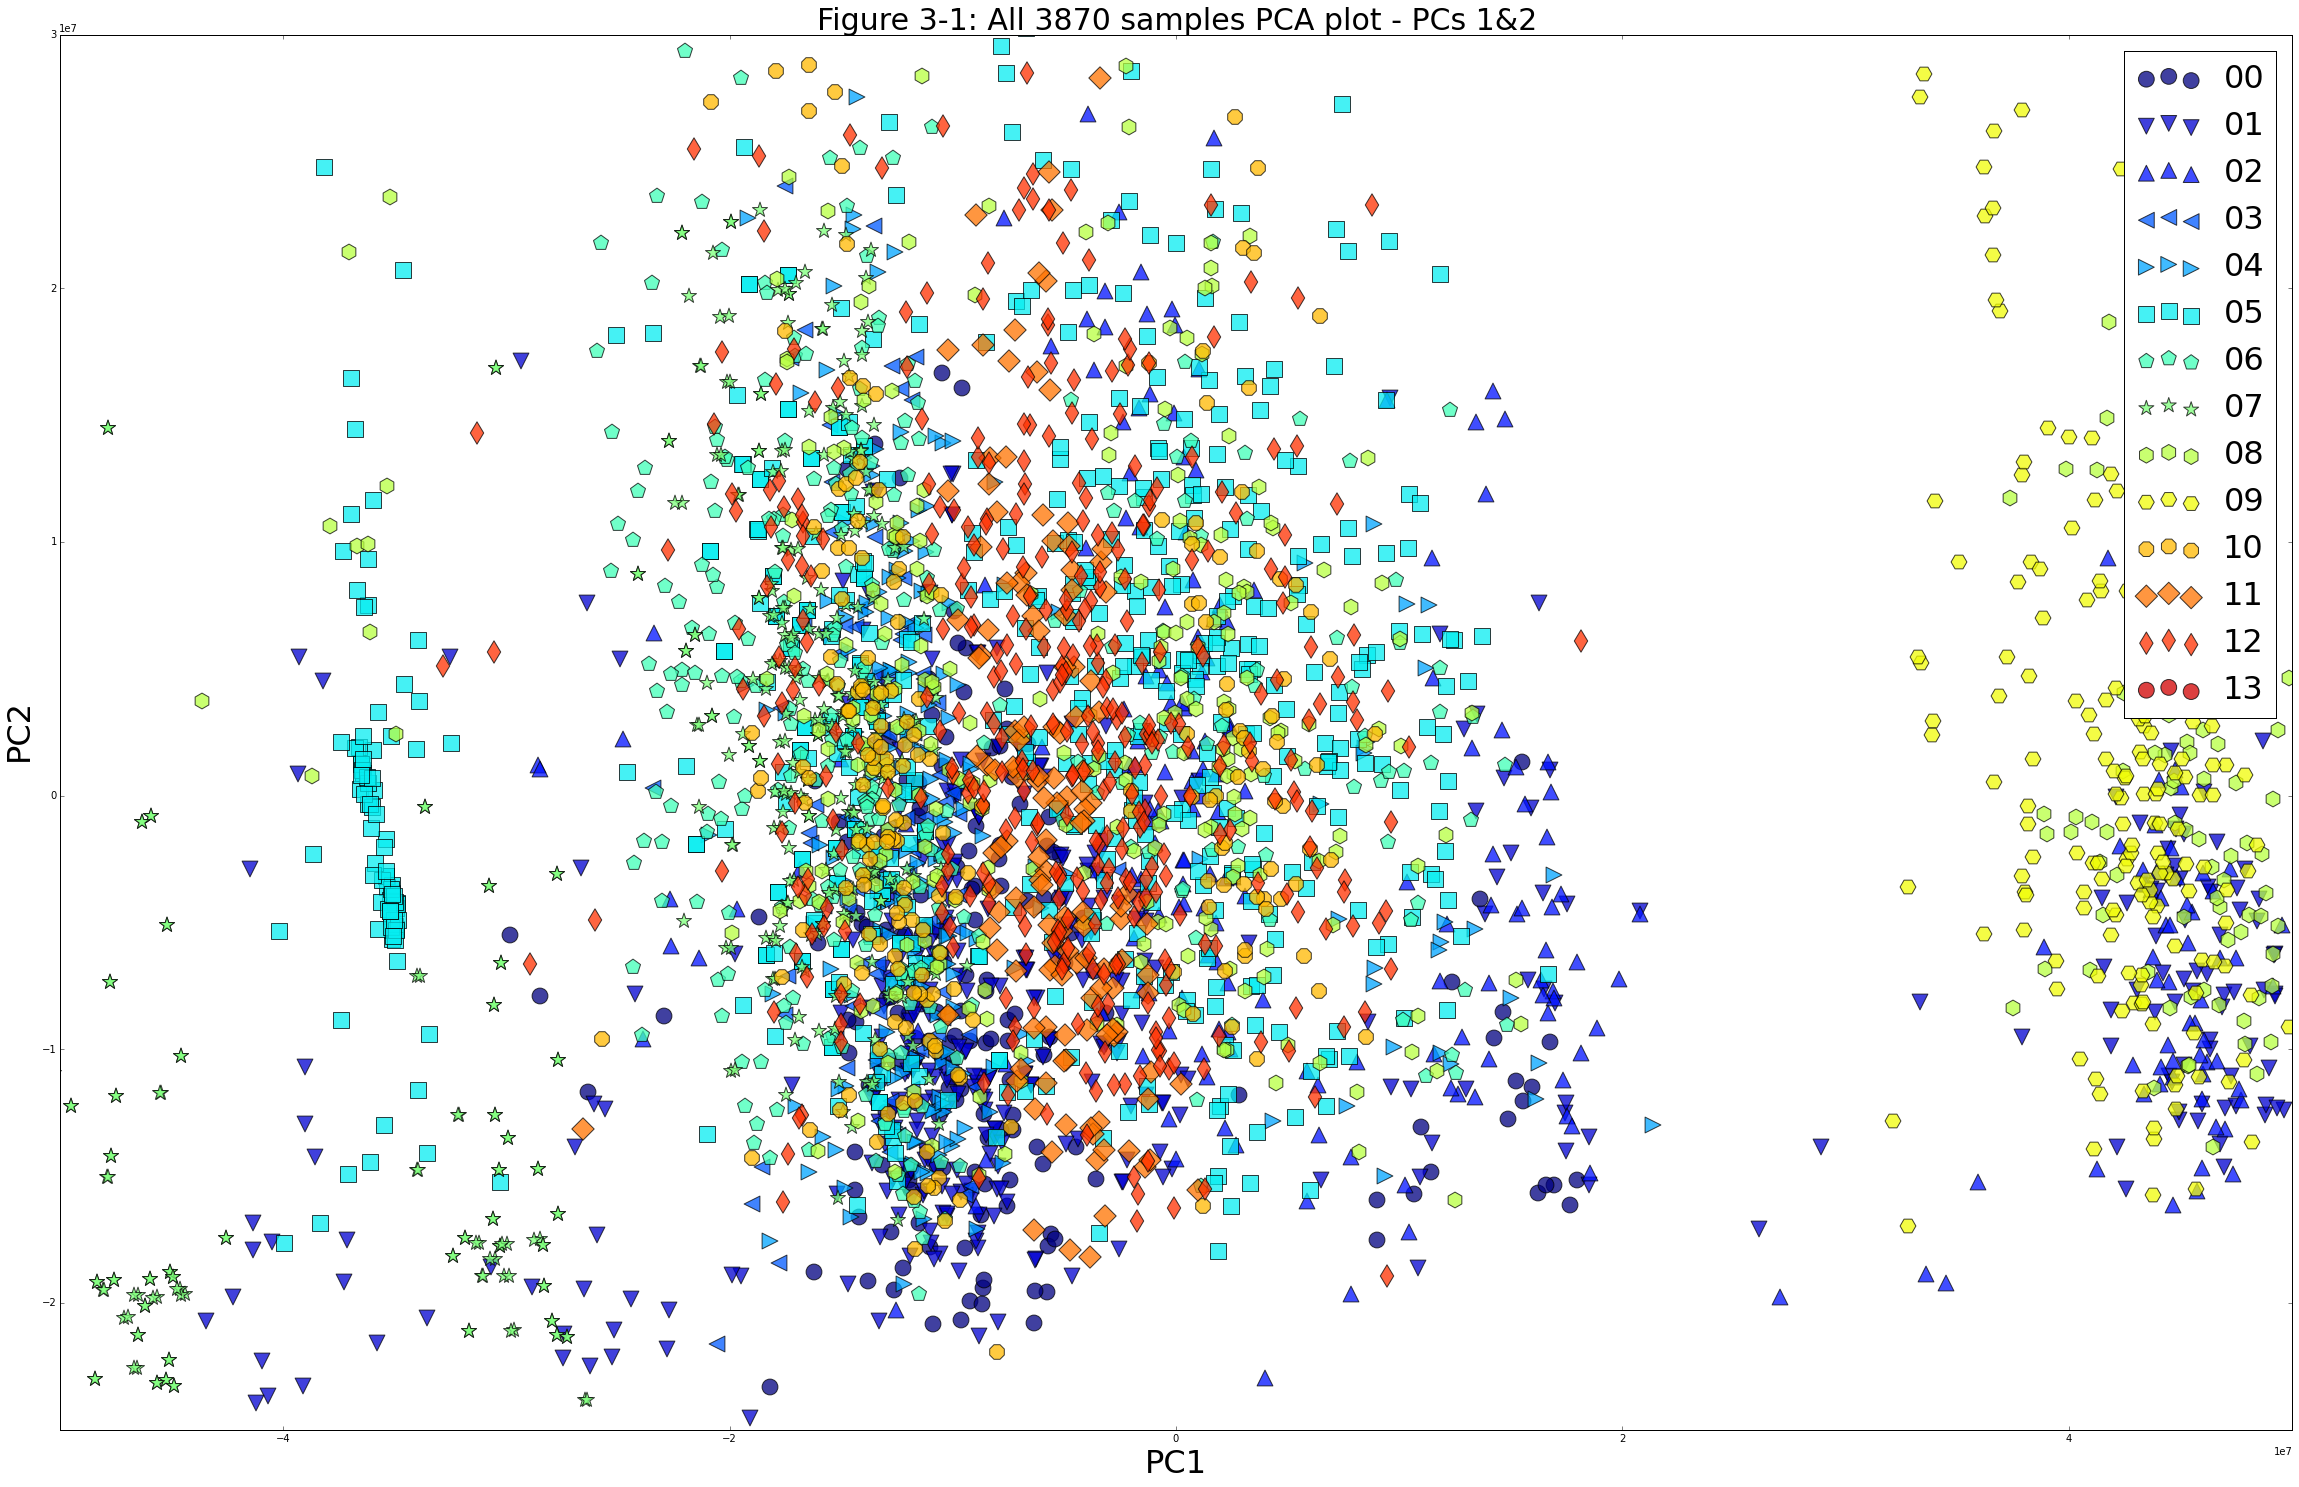

In [86]:
fig, ax = plt.subplots(figsize=(40,25))
ax.set_xlim( ( -5e7, 5e7  ) )
ax.set_xlabel( 'PC1', size=32)
ax.set_ylim( ( -2.5e7, 3e7) )
ax.set_ylabel( 'PC2', size=32)

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_pca_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 0], class_features[:, 1], c=color, label=label, marker=shape, s=250, alpha=0.75)
ax.legend(fontsize=32)
ax.set_title('Figure 3-1: All 3870 samples PCA plot - PCs 1&2', size=30)
fig.show()

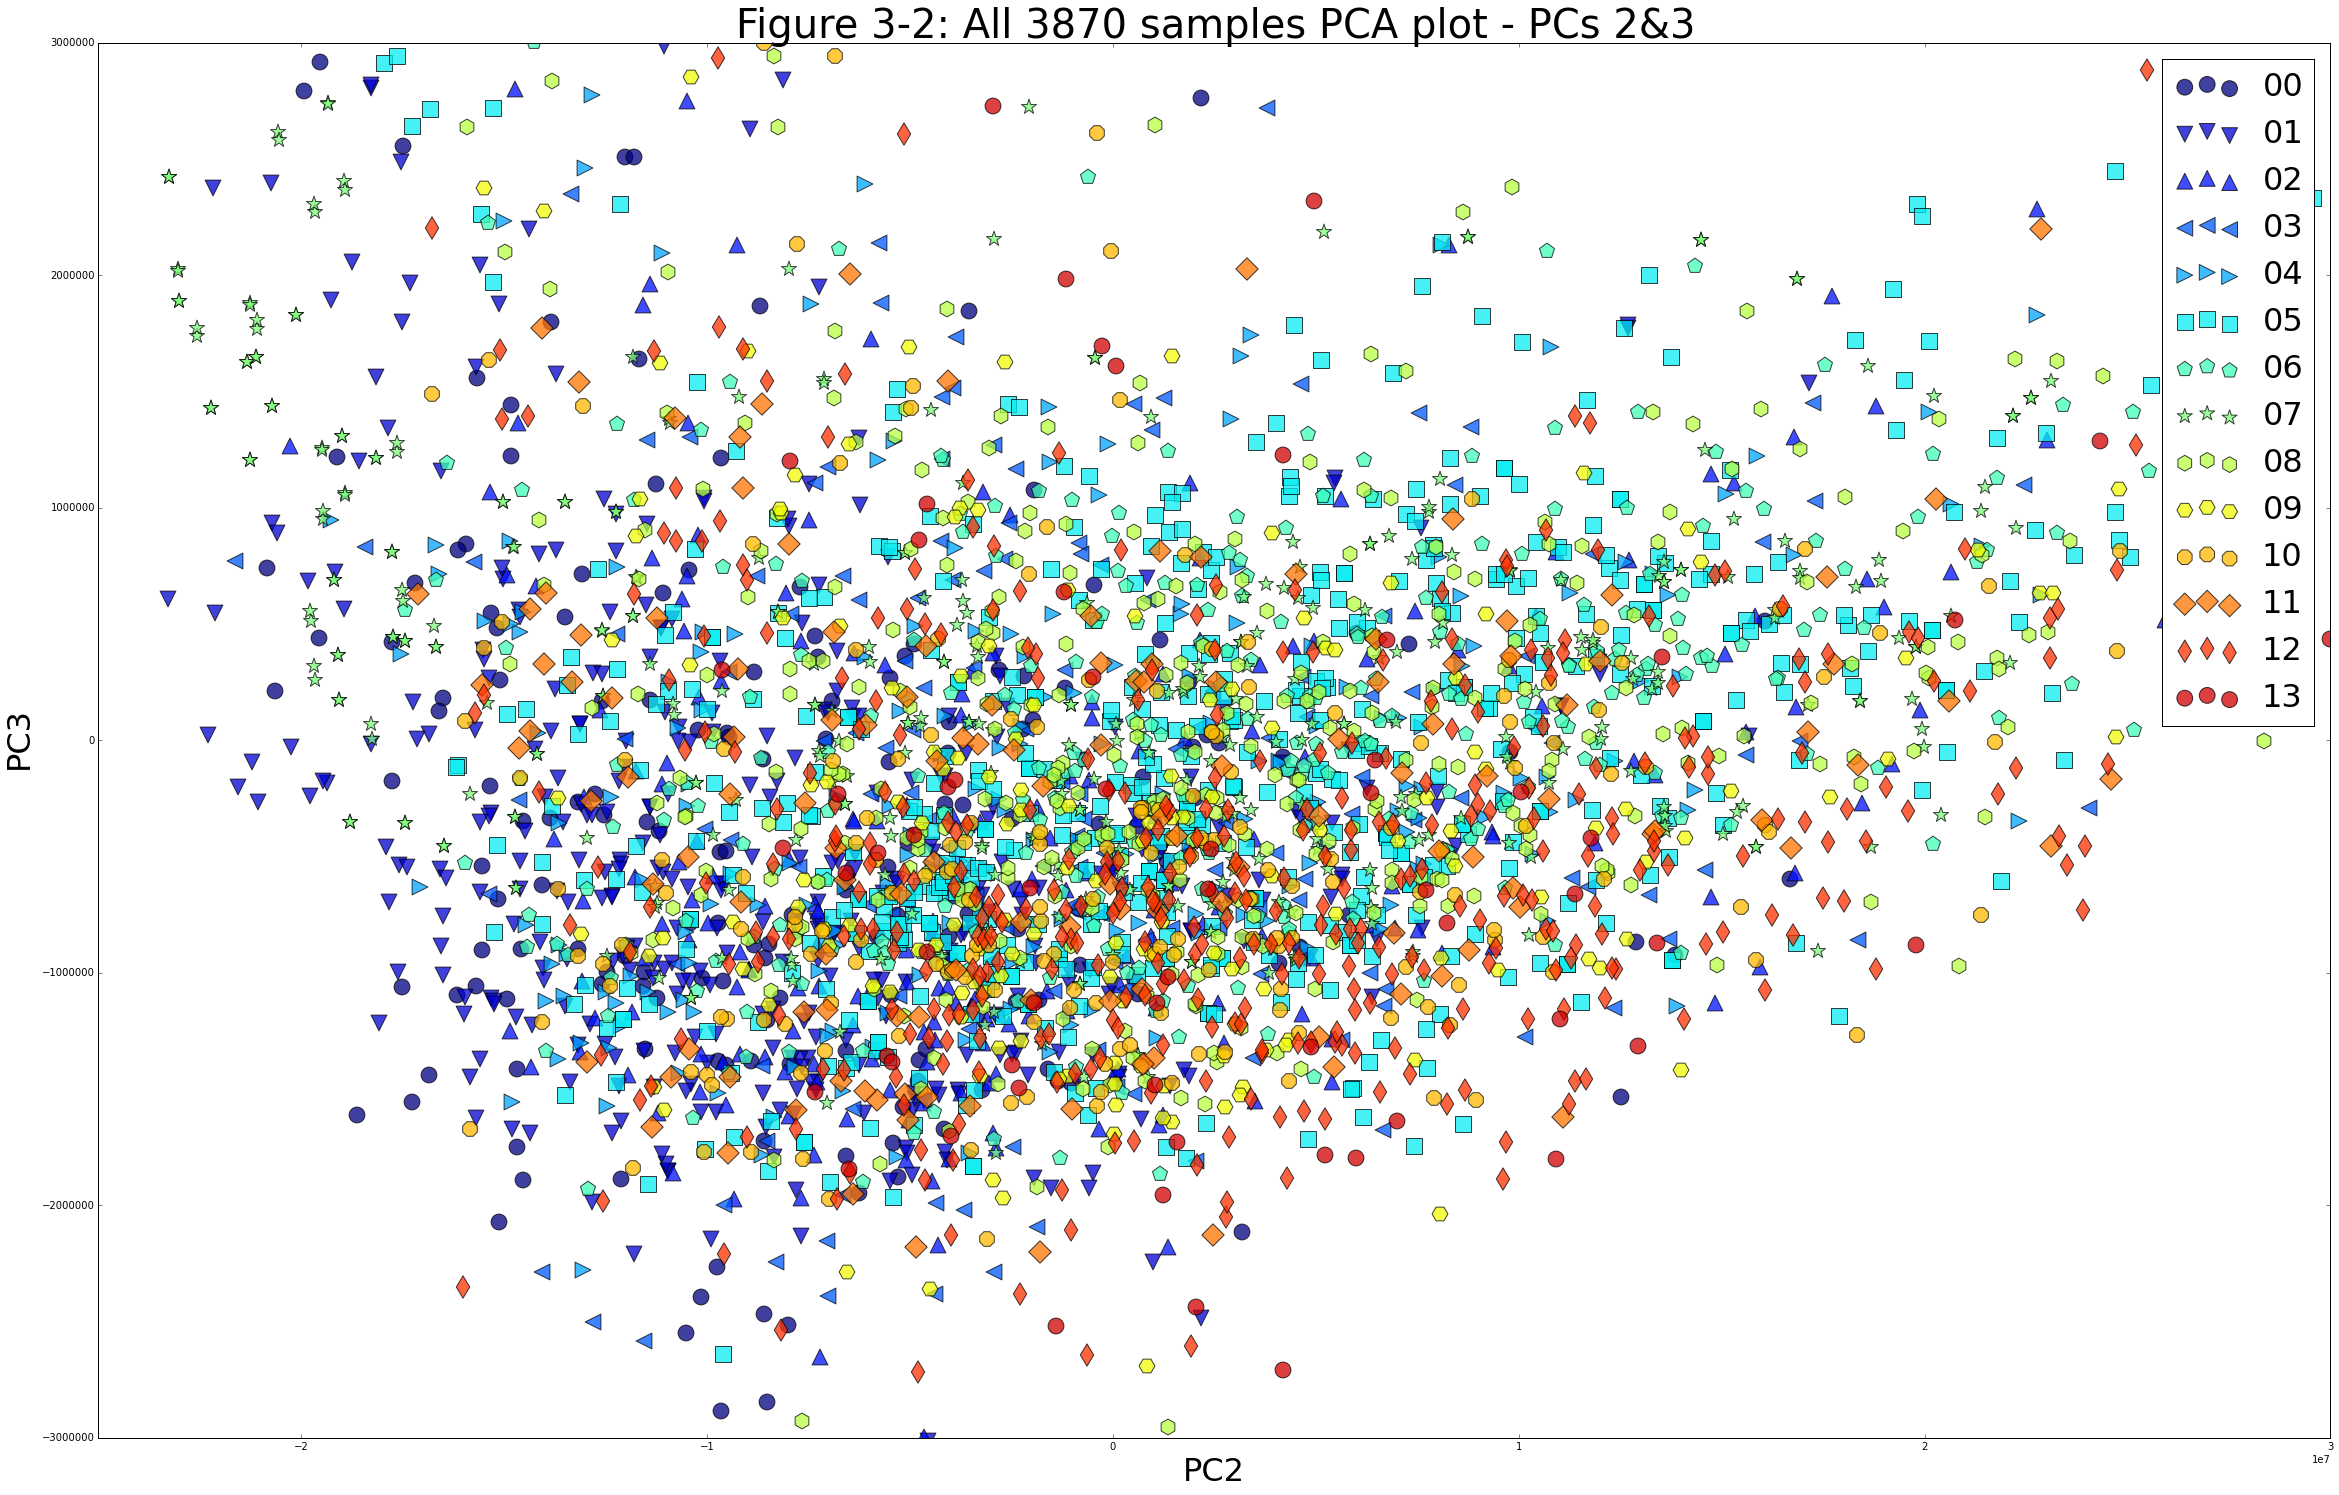

In [87]:
fig, ax = plt.subplots(figsize=(40,25))
ax.set_xlim( ( -2.5e7, 3e7  ) )
ax.set_xlabel( 'PC2', size=32)
ax.set_ylim( ( -0.3e7, 0.3e7) )
ax.set_ylabel( 'PC3', size=32)

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_pca_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 1], class_features[:, 2], c=color, label=label, marker=shape, s=250, alpha=0.75)
ax.legend(fontsize=32)
ax.set_title('Figure 3-2: All 3870 samples PCA plot - PCs 2&3', size=40)
fig.show()

## LDA of 3870 Pharynxes

In [88]:
all_lda_fitter = LDA()
all_lda_fitter.fit( age.data_matrix, age._contiguous_ground_truth_labels )
all_lda_featurespace = all_lda_fitter.transform( age.data_matrix )

In [89]:
all_lda_fitter.priors_

array([ 0.04651163,  0.10645995,  0.0620155 ,  0.04315245,  0.05555556,
        0.15219638,  0.08165375,  0.10465116,  0.09147287,  0.04418605,
        0.05193798,  0.0369509 ,  0.10490956,  0.01834625])

Like PCA, LDA dimensions are ordered with most informative features first, see:

In [90]:
mins = all_lda_featurespace.min(axis=0)
maxs = all_lda_featurespace.max(axis=0)
stdevs = all_lda_featurespace.std(axis=0)

for i, (n,x,d) in enumerate( zip( mins, maxs, stdevs) ):
    print i, n, x, d

0 -8.53713376191 19.5857918083 4.30798239155
1 -5.95686078074 18.0939996295 3.61413836616
2 -9.35483248153 7.55481033464 2.97594938997
3 -13.2777377068 5.23935051619 2.57680870425
4 -6.69868914227 7.33296158677 2.21972225599
5 -7.27967034059 7.95286245445 2.13434019444
6 -9.21717161597 6.78607968146 2.05664430213
7 -5.0539526534 8.10041072512 1.8582264038
8 -6.37089611012 5.99130213481 1.90425654692
9 -6.40237684945 5.16585385154 1.86832335623
10 -4.93882495699 6.94245238694 1.81232436884
11 -5.28369253855 5.91468344119 1.74724315827
12 -5.83906919996 5.522359225 1.71825011587
13 -2.1151566069 0.560000015555 0.438781267358


In [91]:
all_lda_featurespace.shape

(3870, 14)

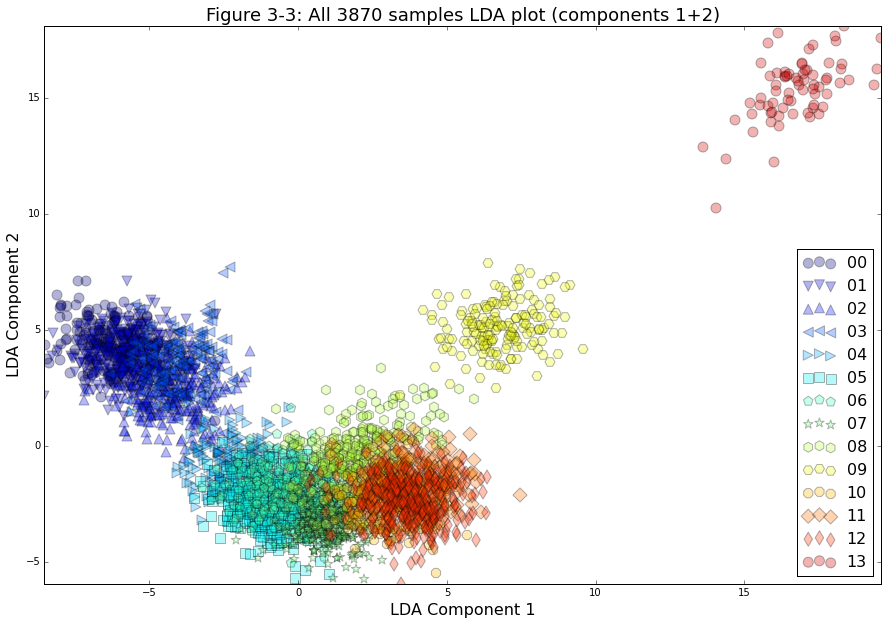

In [92]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( all_lda_featurespace[:,0].min(), all_lda_featurespace[:,0].max() ) )
#ax.set_xlim( ( -10, 10 ) )
ax.set_xlabel( 'LDA Component 1', size=16)
ax.set_ylim( ( all_lda_featurespace[:,1].min(), all_lda_featurespace[:,1].max() ) )
#ax.set_ylim( ( -7, 7 ))
ax.set_ylabel( 'LDA Component 2', size=16)

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_lda_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 0], class_features[:, 1], c=color, label=label, marker=shape, s=100, alpha=0.3)
ax.legend( fontsize=16, loc='lower right' )
ax.set_title('Figure 3-3: All 3870 samples LDA plot (components 1+2)', size=18)
fig.show()

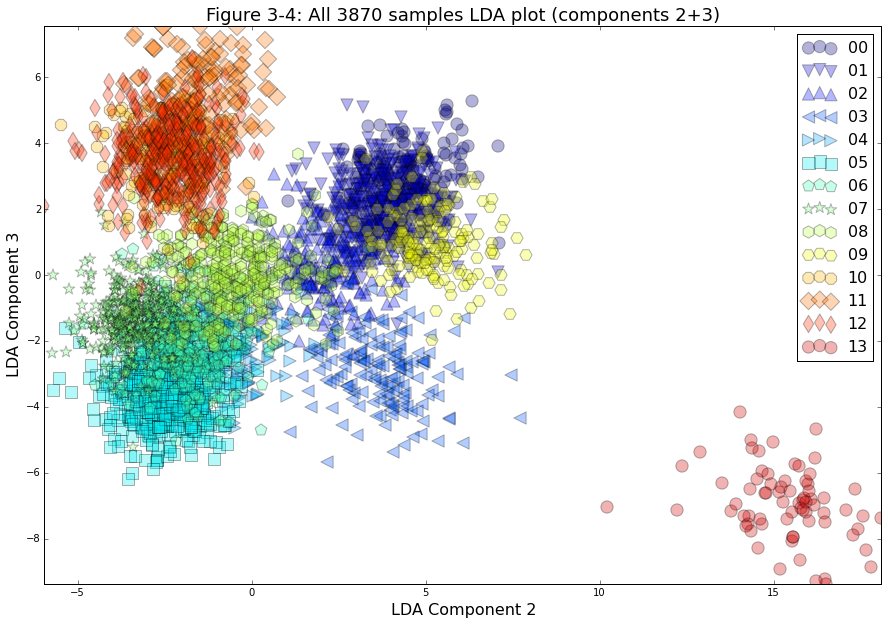

In [93]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( all_lda_featurespace[:,1].min(), all_lda_featurespace[:,1].max() ) )
#ax.set_xlim( ( -7, 7 ) )
ax.set_xlabel( 'LDA Component 2', size=16)
ax.set_ylim( ( all_lda_featurespace[:,2].min(), all_lda_featurespace[:,2].max() ) )
#ax.set_ylim( ( -7, 7 ))
ax.set_ylabel( 'LDA Component 3', size=16)

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_lda_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 1], class_features[:, 2], c=color, label=label, marker=shape, s=150, alpha=0.3)
ax.legend(fontsize=16)
ax.set_title('Figure 3-4: All 3870 samples LDA plot (components 2+3)', size=18)
fig.show()

## WND-CHARM on all 3870 pharynxes

Restart the IPython kernel to clear memory.

In [1]:
from wndcharm.FeatureSpace import FeatureSpace

In [2]:
from wndcharm.FeatureSpacePredictionExperiment import FeatureSpaceClassificationExperiment

In [3]:
age = FeatureSpace.NewFromFitFile( 'dme_c_elegans_lifeaspan_v3.2features.fit')

LOADED FEATURE SPACE FROM WND-CHARM .fit FILE dme_c_elegans_lifeaspan_v3.2features.fit: <FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit" n_features=2919 n_total_samples=3870 n_samples_per_group=1 n_classes=14 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "09": 171, "10": 201, "11": 143, "12": 406, "13": 71)>


To see progress as WND-CHARM completes the splits, set progress argument below to True. This serves as a progress indicator.

In [4]:
import time

In [5]:
t1 = time.time()
table31 = FeatureSpaceClassificationExperiment.NewShuffleSplit( age, n_iter=1000, name='Table 3-1: WND-CHARM results for full 3870-Pharynx dataset', \
                                            features_size=0.15, train_size=65, test_size=6, lda=False, progress=False)
t2 = time.time()
print "1000 splits took {:0.2f} minutes to complete".format( (t2-t1)/60 )

1000 splits took 4.74 minutes to complete


So for this particular feature space, 1000 splits took almost 5 minutes, would be faster if we split up the jobs among cores #TBD

In [6]:
table31.Print(150)

FeatureSpaceClassificationExperiment "Table 3-1: WND-CHARM results for full 3870-Pharynx dataset" (1000 iterations)
42841/84000 correct = 51.00 +/- 0.34% w/ 95% conf. (normal approx. interval)
Standard Error: 2.2603
Pearson Corellation Coefficient (r): 0.8286
Coefficient of Determination (r^2): 0.6866
Spearman Coefficient: 0.8218


Confusion Matrix:
  	00	01	02	03	04	05	06	07	08	09	10	11	12	13	|	total	acc.
  	--	--	--	--	--	--	--	--	--	--	--	--	--	--	|	-----	----
00	2825	1055	212	501	545	89	243	125	148	0	172	29	56	0	|	6000	47.08%
01	774	2673	784	196	436	86	108	421	120	196	35	85	86	0	|	6000	44.55%
02	271	789	2761	42	189	741	342	53	257	285	103	29	138	0	|	6000	46.02%
03	879	256	24	3641	512	54	259	186	72	0	79	28	10	0	|	6000	60.68%
04	377	446	125	370	2606	370	982	391	160	0	82	36	55	0	|	6000	43.43%
05	97	74	801	86	441	2314	781	448	403	0	258	43	254	0	|	6000	38.57%
06	194	105	405	216	1098	683	1607	989	286	0	209	66	142	0	|	6000	26.78%
07	117	279	19	189	412	289	1079	2977	267	0	239	61	72	0	|	6000

N.B. Allmost all fractals and pixel intensities.

In [7]:
from wndcharm.visualization import PredictedValuesGraph

In [8]:
graph = PredictedValuesGraph( table31 )

In [9]:
%matplotlib inline

Rendering rank-ordered predicted values graph


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


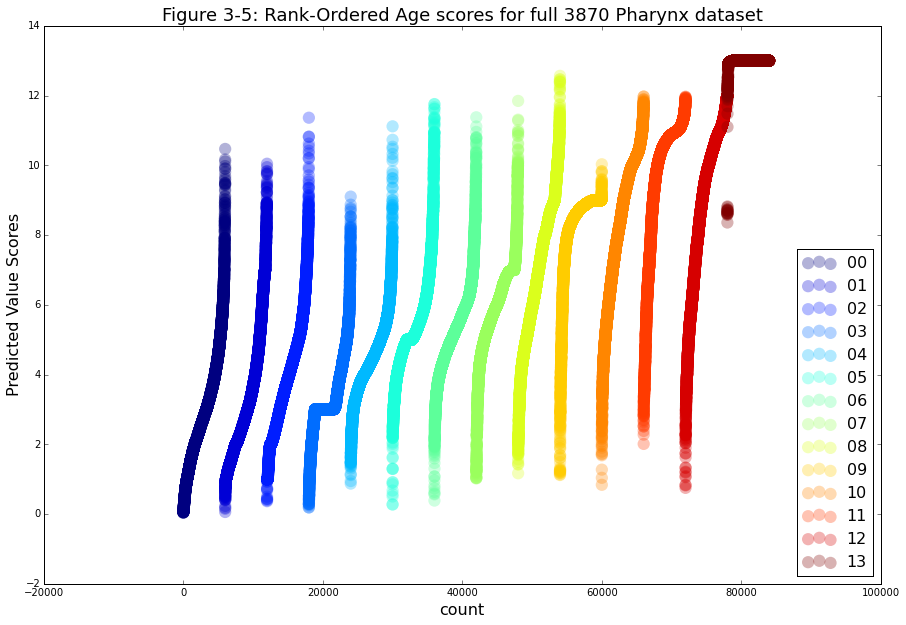

In [10]:
graph.RankOrderedPredictedValuesGraph(chart_title='Figure 3-5: Rank-Ordered Age scores for full 3870 Pharynx dataset')

Rendering kernel-smoothed probability density estimate graph


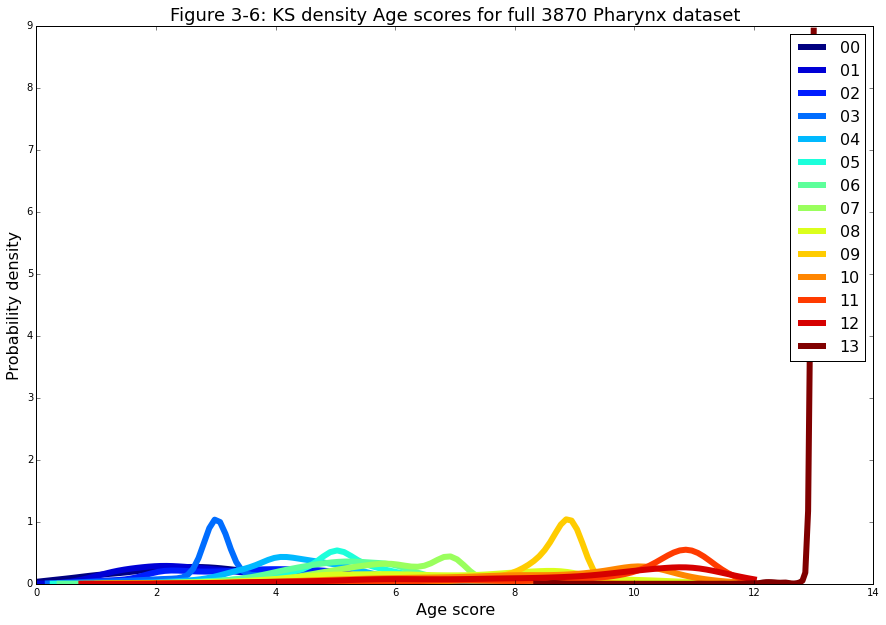

In [11]:
graph.KernelSmoothedDensityGraph(chart_title='Figure 3-6: KS density Age scores for full 3870 Pharynx dataset')

# Section4: Remove days '09' and '13'

From table 3-1 above, days 9 and 13 share essentially no overlap with any other class, and have unusually high in-class classification accuracy, so for the purpose of defining a range of age-related morphologies, let's consider them outliers and remove them from the feature space.

(restart IPython kernel)

In [1]:
from wndcharm.FeatureSpace import FeatureSpace

In [2]:
age = FeatureSpace.NewFromFitFile( 'dme_c_elegans_lifeaspan_v3.2features.fit')

LOADED FEATURE SPACE FROM WND-CHARM .fit FILE dme_c_elegans_lifeaspan_v3.2features.fit: <FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit" n_features=2919 n_total_samples=3870 n_samples_per_group=1 n_classes=14 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "09": 171, "10": 201, "11": 143, "12": 406, "13": 71)>


In [3]:
age.RemoveClass('09', inplace=True)

REMOVED CLASS 09, RESULTANT FEATURE SPACE: <FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted)" n_features=2919 n_total_samples=3699 n_samples_per_group=1 n_classes=13 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "10": 201, "11": 143, "12": 406, "13": 71)>


<FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted)" n_features=2919 n_total_samples=3699 n_samples_per_group=1 n_classes=13 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "10": 201, "11": 143, "12": 406, "13": 71)>

In [4]:
age.RemoveClass('13', inplace=True)

REMOVED CLASS 13, RESULTANT FEATURE SPACE: <FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted) (subset) (sorted)" n_features=2919 n_total_samples=3628 n_samples_per_group=1 n_classes=12 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "10": 201, "11": 143, "12": 406)>


<FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted) (subset) (sorted)" n_features=2919 n_total_samples=3628 n_samples_per_group=1 n_classes=12 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "10": 201, "11": 143, "12": 406)>

In [5]:
from sklearn.lda import LDA

In [6]:
all_lda_fitter = LDA()
all_lda_fitter.fit( age.data_matrix, age._contiguous_ground_truth_labels )
all_lda_featurespace = all_lda_fitter.transform( age.data_matrix )

/usr/local/lib/python2.7/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [7]:
import matplotlib.pyplot as plt

In [8]:
class_labels = age.class_names
class_colors = plt.cm.jet( [ val/len(class_labels) for val in age.interpolation_coefficients] )
class_shapes = list(('o','v','^','<','>','s','p','*','h','H','8','D','d','o'))[:len(class_labels)]

In [9]:
print len(age.class_names), len(class_labels), len(class_colors), len(class_shapes), 12

12 12 12 12 12


In [10]:
import numpy as np

In [11]:
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


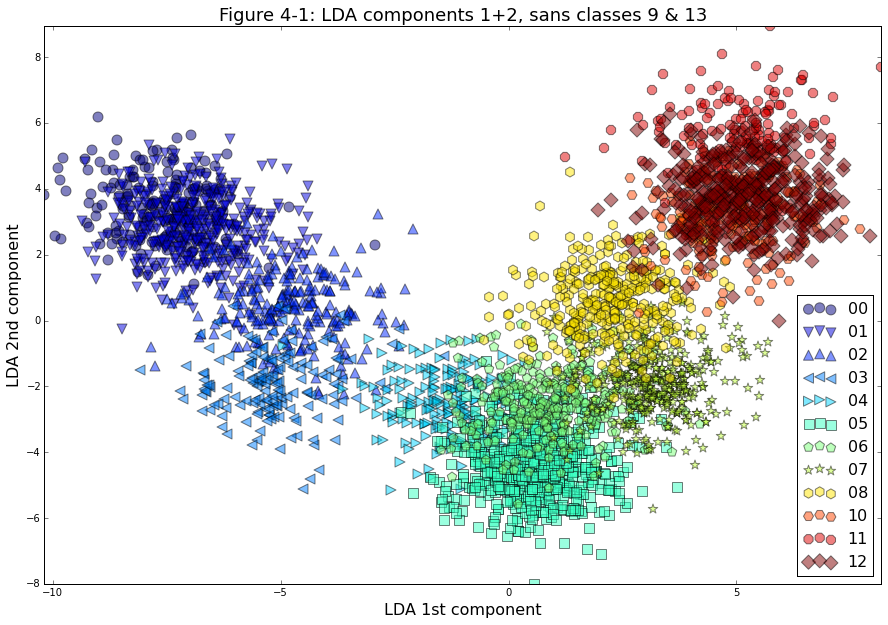

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( all_lda_featurespace[:,0].min(), all_lda_featurespace[:,0].max() ) )
#ax.set_xlim( ( -10, 10 ) )
ax.set_xlabel( 'LDA 1st component', size=16)
ax.set_ylim( ( all_lda_featurespace[:,1].min(), all_lda_featurespace[:,1].max() ) )
#ax.set_ylim( ( -7, 7 ))
ax.set_ylabel( 'LDA 2nd component', size=16 )

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_lda_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 0], class_features[:, 1], c=color, label=label, marker=shape, s=100, alpha=0.5)
ax.legend(fontsize=16, loc='lower right')
ax.set_title('Figure 4-1: LDA components 1+2, sans classes 9 & 13', size=18)
fig.show()

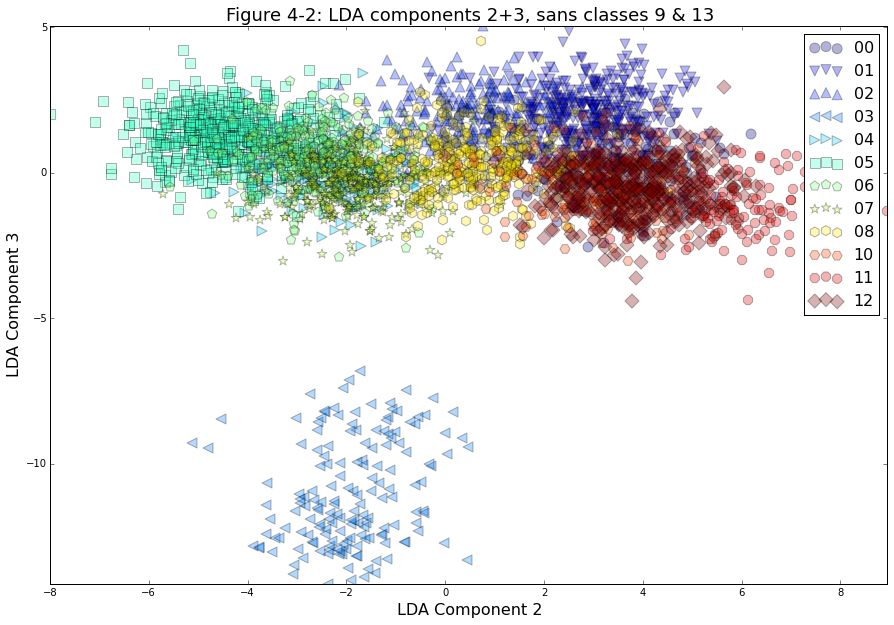

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlim( ( all_lda_featurespace[:,1].min(), all_lda_featurespace[:,1].max() ) )
#ax.set_xlim( ( -7, 7 ) )
ax.set_xlabel( 'LDA Component 2', size=16)
ax.set_ylim( ( all_lda_featurespace[:,2].min(), all_lda_featurespace[:,2].max() ) )
#ax.set_ylim( ( -7, 7 ))
ax.set_ylabel( 'LDA Component 3', size=16)

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_lda_featurespace[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 1], class_features[:, 2], c=color, label=label, marker=shape, s=100, alpha=0.3)
ax.legend(fontsize=16)
ax.set_title('Figure 4-2: LDA components 2+3, sans classes 9 & 13', size=18)
fig.show()

In [14]:
age

<FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted) (subset) (sorted)" n_features=2919 n_total_samples=3628 n_samples_per_group=1 n_classes=12 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "10": 201, "11": 143, "12": 406)>

In [16]:
import time

In [19]:
from wndcharm.FeatureSpacePredictionExperiment import FeatureSpaceClassificationExperiment

In [20]:
t1 = time.time()
table41 = FeatureSpaceClassificationExperiment.NewShuffleSplit( age, n_iter=1000, name="Table 4-1: WND-CHARM results sans days 9+13", \
                                            features_size=0.15, train_size=65, test_size=6, lda=False, progress=False)
t2 = time.time()
print "1000 splits took {:0.2f} minutes to complete".format( (t2-t1)/60 )

1000 splits took 3.89 minutes to complete


The time to complete is obviously proportional to the training and test sets.

In [21]:
table41.Print(150)

FeatureSpaceClassificationExperiment "Table 4-1: WND-CHARM results sans days 9+13" (1000 iterations)
33156/72000 correct = 46.05 +/- 0.36% w/ 95% conf. (normal approx. interval)
Standard Error: 2.2592
Pearson Corellation Coefficient (r): 0.8066
Coefficient of Determination (r^2): 0.6506
Spearman Coefficient: 0.7979


Confusion Matrix:
  	00	01	02	03	04	05	06	07	08	10	11	12	|	total	acc.
  	--	--	--	--	--	--	--	--	--	--	--	--	|	-----	----
00	3184	1118	166	447	349	57	317	118	78	91	19	56	|	6000	53.07%
01	859	2906	844	162	299	70	155	397	186	23	43	56	|	6000	48.43%
02	318	816	3040	44	247	646	356	68	291	65	5	104	|	6000	50.67%
03	981	242	1	3768	320	43	347	123	38	80	40	17	|	6000	62.80%
04	320	444	147	189	2629	469	1154	347	129	101	37	34	|	6000	43.82%
05	75	61	734	58	512	2540	888	391	291	180	46	224	|	6000	42.33%
06	183	92	405	125	1035	788	1812	933	300	160	51	116	|	6000	30.20%
07	70	179	25	81	404	314	1127	3048	285	268	92	107	|	6000	50.80%
08	97	248	693	28	222	463	504	460	1801	583	336	565	|	6000	30.

N.B. Zernike starting to win out over the fractals and pixel stats.

In [23]:
from wndcharm.visualization import PredictedValuesGraph

In [24]:
graph = PredictedValuesGraph( table41 )

Rendering rank-ordered predicted values graph


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


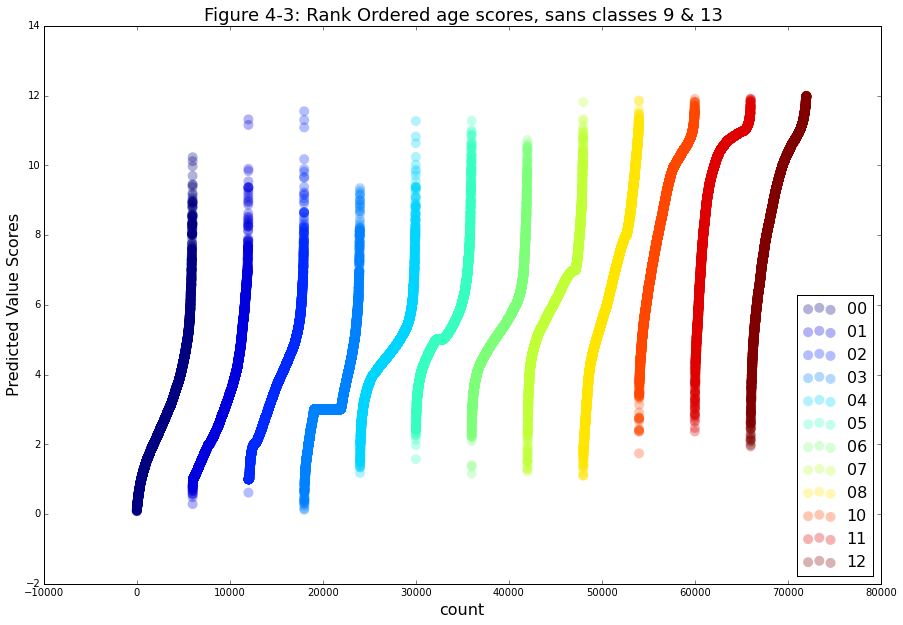

In [25]:
graph.RankOrderedPredictedValuesGraph(chart_title='Figure 4-3: Rank Ordered age scores, sans classes 9 & 13')

Rendering kernel-smoothed probability density estimate graph


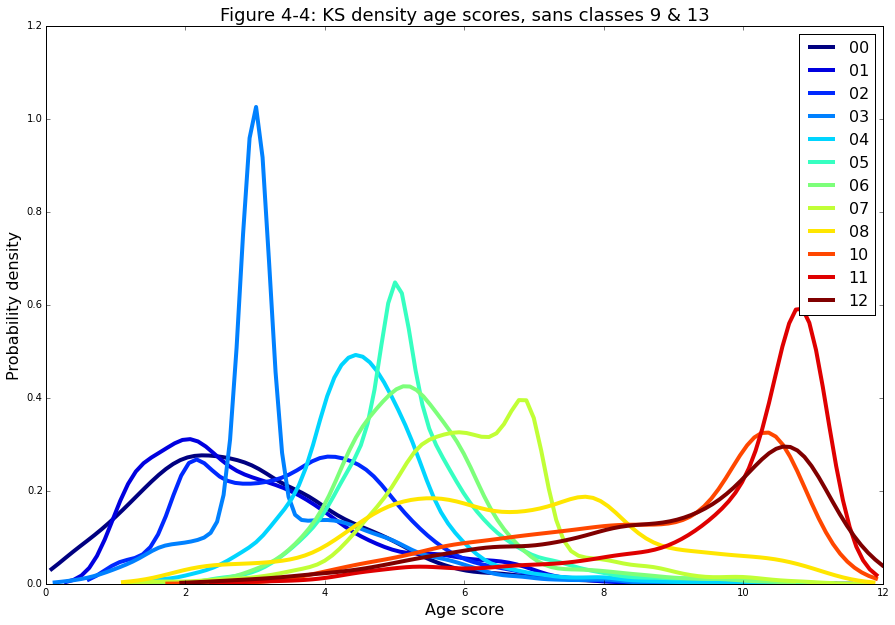

In [26]:
graph.KernelSmoothedDensityGraph(chart_title='Figure 4-4: KS density age scores, sans classes 9 & 13')

# Section 5: Remove artifactually high peaks from Kernel smoothed graph

Looking at the intra-class PCA graphs shown above, some intra-class worm preparations don't look like the others. Clumpings of like-named samples is a red flag. Marginal probabilities that show 1.000 in the ground truth class and 0's in the others is a red flag (data not shown, do an exp.PerSampleStatistics() to see).

Removing samples with the following prefixes:
* "./03/3.2"
* "./05/5pharynx"
* "./07/7.1"

This will make the Rank Ordered plots more smooth.

In [27]:
remove_set = ( "./03/3.2", "./05/5pharynx", "./07/7.1", )

In [28]:
baddie_list = [ i for i, name in enumerate( age._contiguous_sample_names ) if name.startswith( remove_set ) ]

In [29]:
len(baddie_list)

301

In [30]:
age

<FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted) (subset) (sorted)" n_features=2919 n_total_samples=3628 n_samples_per_group=1 n_classes=12 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 167, "04": 215, "05": 589, "06": 316, "07": 405, "08": 354, "10": 201, "11": 143, "12": 406)>

In [31]:
age2 = age.SampleReduce(None, baddie_list)

SAMPLE REDUCED FEATURE SPACE:  <FeatureSpace "dme_c_elegans_lifeaspan_v3.2features.fit (subset) (sorted) (subset) (sorted) (subset) (sorted)" n_features=2919 n_total_samples=3327 n_samples_per_group=1 n_classes=12 samples_per_class=("00": 180, "01": 412, "02": 240, "03": 87, "04": 215, "05": 500, "06": 316, "07": 273, "08": 354, "10": 201, "11": 143, "12": 406)>


In [32]:
t1 = time.time()
table51 = FeatureSpaceClassificationExperiment.NewShuffleSplit( age2, n_iter=1000, name="Table 5-1: WND-CHARM results w/curated feature space", \
                                            features_size=0.15, train_size=65, test_size=6, lda=False, progress=False)
t2 = time.time()
print "1000 splits took {:0.2f} minutes to complete".format( (t2-t1)/60 )

1000 splits took 3.85 minutes to complete


In [33]:
table51.Print(150)

FeatureSpaceClassificationExperiment "Table 5-1: WND-CHARM results w/curated feature space" (1000 iterations)
34043/72000 correct = 47.28 +/- 0.36% w/ 95% conf. (normal approx. interval)
Standard Error: 2.2075
Pearson Corellation Coefficient (r): 0.8225
Coefficient of Determination (r^2): 0.6765
Spearman Coefficient: 0.8210


Confusion Matrix:
  	00	01	02	03	04	05	06	07	08	10	11	12	|	total	acc.
  	--	--	--	--	--	--	--	--	--	--	--	--	|	-----	----
00	2951	991	149	1189	236	28	200	138	26	40	0	52	|	6000	49.18%
01	795	3238	855	442	177	55	108	125	119	18	9	59	|	6000	53.97%
02	245	729	3221	112	141	886	204	107	218	57	7	73	|	6000	53.68%
03	666	236	0	3915	389	54	319	282	20	73	38	8	|	6000	65.25%
04	273	323	97	668	2426	657	851	526	102	48	5	24	|	6000	40.43%
05	38	31	617	124	433	2719	751	671	283	111	33	189	|	6000	45.32%
06	118	50	312	334	789	933	1485	1520	200	106	45	108	|	6000	24.75%
07	31	43	6	211	377	249	1118	3211	207	360	96	91	|	6000	53.52%
08	68	179	623	44	139	571	332	837	1892	532	281	502	|	6000	3

N.B. Fractals gone from the top 50

In [34]:
graph = PredictedValuesGraph( table51 )

Rendering rank-ordered predicted values graph


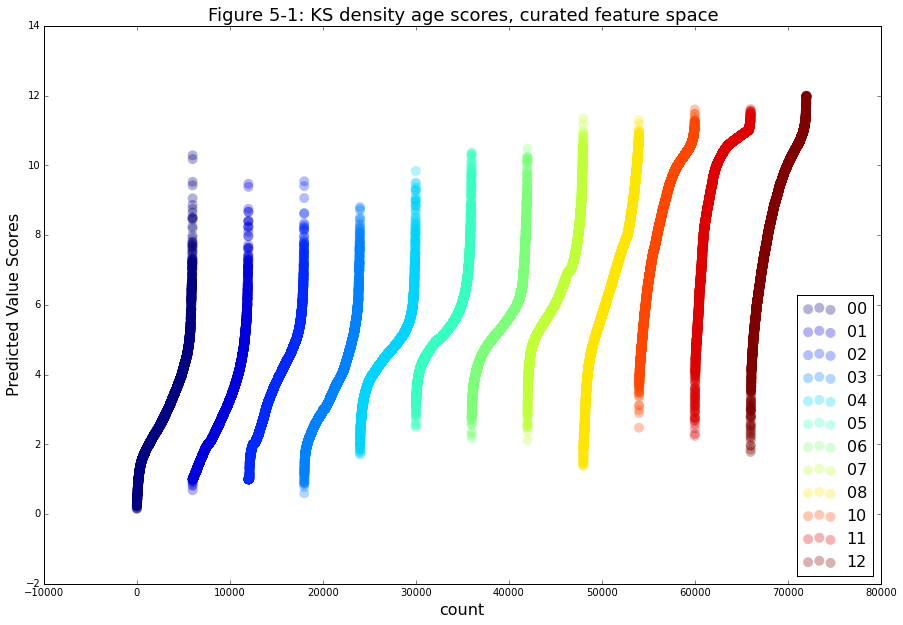

In [35]:
graph.RankOrderedPredictedValuesGraph(chart_title='Figure 5-1: KS density age scores, curated feature space')

Rendering kernel-smoothed probability density estimate graph


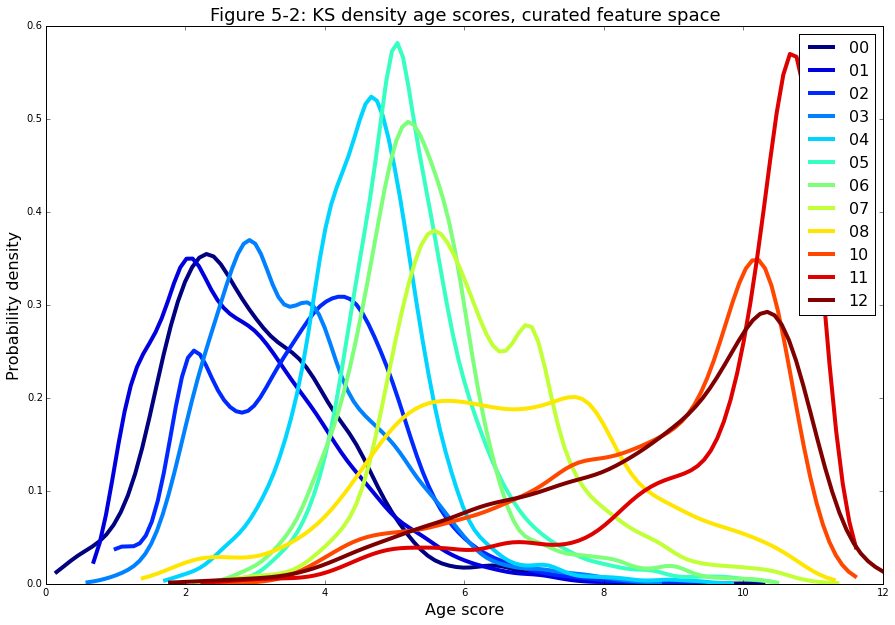

In [36]:
graph.KernelSmoothedDensityGraph(chart_title='Figure 5-2: KS density age scores, curated feature space')

In [37]:
age2.ToFitFile('dme_c_elegans_lifeaspan_v3.2features_curated.fit')

## WND-CHARM results discussion

After curation, in figure 5-1 the discontinuous horizontal bars in figure 4-3 are gone, and the shared peaks are starting to converge nicely in figure 5-2.

# LDA analysis or curated data set

In [38]:
from sklearn.lda import LDA

In [39]:
all_lda_fitter2 = LDA()
all_lda_fitter2.fit( age2.data_matrix, age2._contiguous_ground_truth_labels )
all_lda_featurespace2 = all_lda_fitter2.transform( age2.data_matrix )

In [40]:
import matplotlib.pyplot as plt

In [41]:
class_labels = age2.class_names
class_colors = plt.cm.jet( [ val/len(class_labels) for val in age.interpolation_coefficients] )
class_shapes = list(('o','v','^','<','>','s','p','*','h','H','8','D','d','o'))[:len(class_labels)]

In [42]:
import numpy as np

# LDA w/ curated feature space

In [43]:
%matplotlib inline

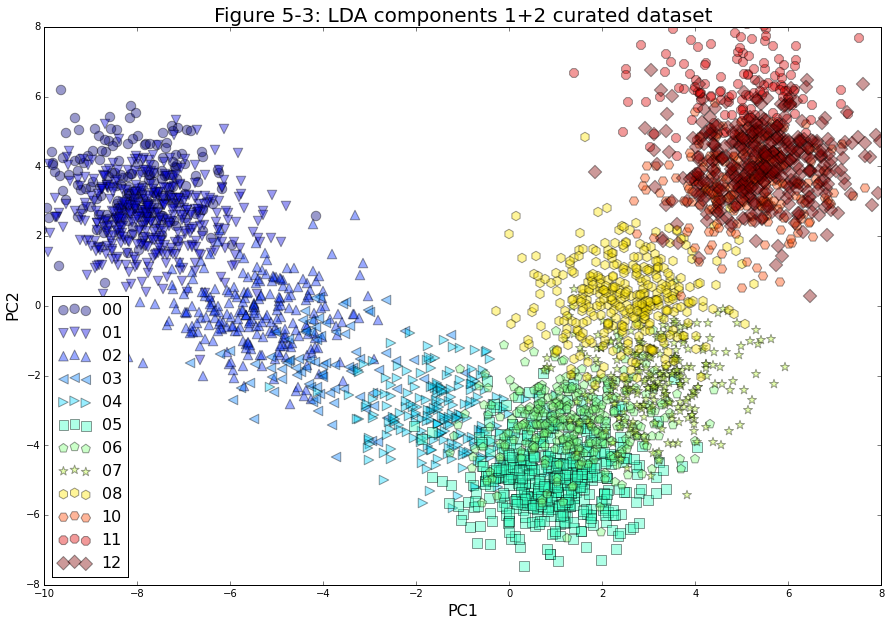

In [47]:
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_xlim( ( all_lda_featurespace2[:,0].min(), all_lda_featurespace2[:,0].max()*1.5 ) )
ax.set_xlim( ( -10, 8 ) )
ax.set_xlabel( 'PC1', size=16)
#ax.set_ylim( ( all_lda_featurespace2[:,1].min(), all_lda_featurespace2[:,1].max()*1.5 ))
ax.set_ylim( ( -8, 8 ) )
ax.set_ylabel( 'PC2', size=16 )

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age2._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_lda_featurespace2[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 0], class_features[:, 1], c=color, label=label, marker=shape, s=90, alpha=0.4)
ax.legend(loc='lower left', fontsize=16 )
ax.set_title('Figure 5-3: LDA components 1+2 curated dataset', size=20)

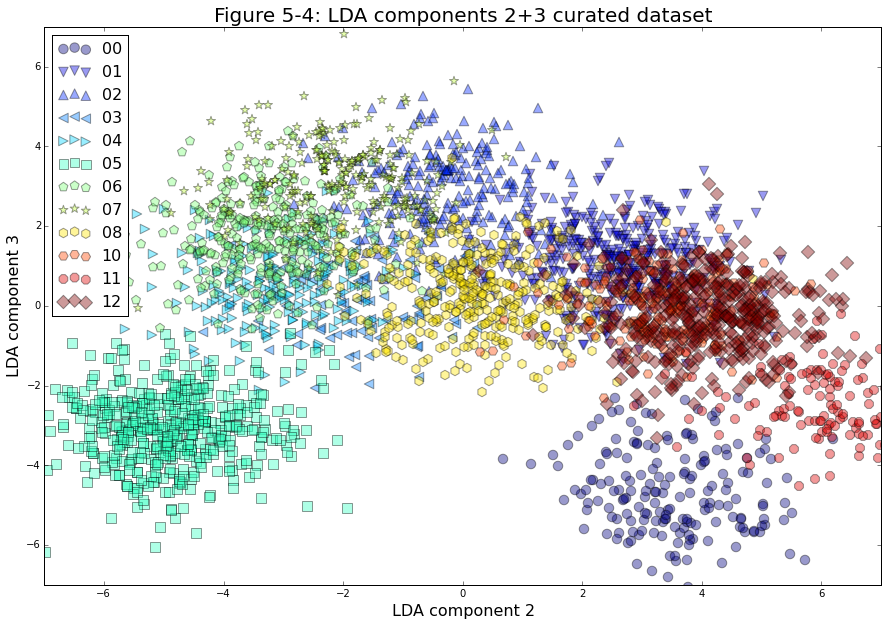

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_xlim( ( all_lda_featurespace2[:,1].min(), all_lda_featurespace2[:,1].max()*1.5 ) )
ax.set_xlim( ( -7, 7 ) )
ax.set_xlabel( 'LDA component 2', size=16)
#ax.set_ylim( ( all_lda_featurespace2[:,2].min(), all_lda_featurespace2[:,2].max()*1.5 ))
ax.set_ylim( ( -7, 7 ) )
ax.set_ylabel( 'LDA component 3', size=16)

for label, color, shape in zip( class_labels, class_colors, class_shapes ):
    indices = np.where( [ gt == label for gt in age2._contiguous_ground_truth_labels ] )
    #print "============================================\n", class_name
    #print indices
    class_features = all_lda_featurespace2[ indices ]
    #print class_features.shape
    ax.scatter( class_features[:, 1], class_features[:, 2], c=color, label=label, marker=shape, s=90, alpha=0.4)
ax.legend(loc=2, fontsize=16)
ax.set_title('Figure 5-4: LDA components 2+3 curated dataset', size=20)

Looking at figure 5-4, curation made class 03 more well-behaved compared to class 03 in figure 4-2.

In [48]:
exp.PerSampleStatistics(print_indiv=False, output_filepath='dme_c_elegans_curated2_bagged-i65-j6-n1000.tsv')

Saving output of function "PerSampleStatistics()" to file "dme_c_elegans_curated2_bagged-i65-j6-n1000.tsv", mode "w"


<FeatureSpaceClassificationExperiment #1 "WND-CHARM curated data set 2" n_splits=1000 n_calls=72000 n_corr=33910 acc=47.10% std_err=1.55%>